In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

In [3]:
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

In [4]:
#filename = '/content/drive/My Drive/luna_lab/car_plate_sample/'
filename = './augmented_data/'

In [43]:
trans = torchvision.transforms.Compose([
                                        transforms.Resize((224,224)), #image net의 input 형태
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5),(0.5))
                                        ])

In [44]:
dataset = torchvision.datasets.ImageFolder(root = filename,
                                        transform = trans)

In [45]:
classes = dataset.classes

In [46]:
print(len(classes))

82


In [47]:
validation_split = .3
shuffle_dataset = True
random_seed= 42

In [48]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [49]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=4, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                                sampler=valid_sampler)

In [13]:
model_name = 'efficientnet-b0'  # b5
image_size = EfficientNet.get_image_size(model_name)
model = EfficientNet.from_pretrained(model_name, num_classes=82)

Loaded pretrained weights for efficientnet-b0


In [19]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [51]:
log_interval = 200

In [56]:
for epoch in tqdm(range(3)):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()
        
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % log_interval == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 4.458228
Train Epoch: 0 Loss: 3.776228
Train Epoch: 0 Loss: 3.496870


RuntimeError: python_error

In [58]:
PATH = './car_efficientNet.pth'
torch.save(model.state_dict(), PATH)

In [59]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

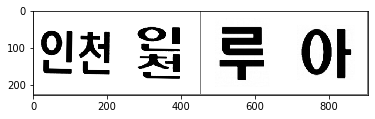

GroundTruth:      d    dv    fn    dk


In [60]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [62]:
net = model
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [63]:
outputs = net(images)

In [64]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(1)))

Predicted:      m


In [65]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (100 * correct / total))



  0%|                                                                                         | 0/8615 [00:00<?, ?it/s]

  0%|                                                                               | 1/8615 [00:00<1:07:37,  2.12it/s]

  0%|                                                                               | 2/8615 [00:00<1:07:22,  2.13it/s]

  0%|                                                                               | 3/8615 [00:01<1:10:06,  2.05it/s]

  0%|                                                                               | 4/8615 [00:01<1:10:07,  2.05it/s]

  0%|                                                                               | 5/8615 [00:02<1:08:59,  2.08it/s]

  0%|                                                                               | 6/8615 [00:02<1:09:33,  2.06it/s]

  0%|                                                                               | 7/8615 [00:03<1:10:19,  2.04it/s]

  0%|                         

  1%|▌                                                                             | 64/8615 [00:37<1:36:03,  1.48it/s]

  1%|▌                                                                             | 65/8615 [00:38<1:34:50,  1.50it/s]

  1%|▌                                                                             | 66/8615 [00:38<1:30:56,  1.57it/s]

  1%|▌                                                                             | 67/8615 [00:39<1:29:09,  1.60it/s]

  1%|▌                                                                             | 68/8615 [00:40<1:36:27,  1.48it/s]

  1%|▌                                                                             | 69/8615 [00:40<1:35:27,  1.49it/s]

  1%|▋                                                                             | 70/8615 [00:41<1:35:50,  1.49it/s]

  1%|▋                                                                             | 71/8615 [00:42<1:41:23,  1.40it/s]

  1%|▋                          

  1%|█▏                                                                           | 128/8615 [01:26<2:28:20,  1.05s/it]

  1%|█▏                                                                           | 129/8615 [01:27<2:14:24,  1.05it/s]

  2%|█▏                                                                           | 130/8615 [01:27<2:08:45,  1.10it/s]

  2%|█▏                                                                           | 131/8615 [01:28<2:02:01,  1.16it/s]

  2%|█▏                                                                           | 132/8615 [01:29<2:07:21,  1.11it/s]

  2%|█▏                                                                           | 133/8615 [01:30<2:10:52,  1.08it/s]

  2%|█▏                                                                           | 134/8615 [01:31<2:15:52,  1.04it/s]

  2%|█▏                                                                           | 135/8615 [01:32<2:02:45,  1.15it/s]

  2%|█▏                         

  2%|█▋                                                                           | 192/8615 [02:10<1:25:28,  1.64it/s]

  2%|█▋                                                                           | 193/8615 [02:11<1:26:45,  1.62it/s]

  2%|█▋                                                                           | 194/8615 [02:12<1:28:00,  1.59it/s]

  2%|█▋                                                                           | 195/8615 [02:12<1:28:56,  1.58it/s]

  2%|█▊                                                                           | 196/8615 [02:13<1:29:22,  1.57it/s]

  2%|█▊                                                                           | 197/8615 [02:13<1:28:13,  1.59it/s]

  2%|█▊                                                                           | 198/8615 [02:14<1:29:20,  1.57it/s]

  2%|█▊                                                                           | 199/8615 [02:15<1:30:48,  1.54it/s]

  2%|█▊                         

  3%|██▎                                                                          | 256/8615 [02:54<1:38:15,  1.42it/s]

  3%|██▎                                                                          | 257/8615 [02:55<1:35:26,  1.46it/s]

  3%|██▎                                                                          | 258/8615 [02:56<1:37:59,  1.42it/s]

  3%|██▎                                                                          | 259/8615 [02:56<1:37:50,  1.42it/s]

  3%|██▎                                                                          | 260/8615 [02:57<1:34:48,  1.47it/s]

  3%|██▎                                                                          | 261/8615 [02:58<1:32:23,  1.51it/s]

  3%|██▎                                                                          | 262/8615 [02:58<1:31:46,  1.52it/s]

  3%|██▎                                                                          | 263/8615 [02:59<1:33:05,  1.50it/s]

  3%|██▎                        

  4%|██▊                                                                          | 320/8615 [03:41<1:35:22,  1.45it/s]

  4%|██▊                                                                          | 321/8615 [03:42<1:40:17,  1.38it/s]

  4%|██▉                                                                          | 322/8615 [03:43<1:39:04,  1.40it/s]

  4%|██▉                                                                          | 323/8615 [03:43<1:35:51,  1.44it/s]

  4%|██▉                                                                          | 324/8615 [03:44<1:33:39,  1.48it/s]

  4%|██▉                                                                          | 325/8615 [03:45<1:35:50,  1.44it/s]

  4%|██▉                                                                          | 326/8615 [03:46<1:48:20,  1.28it/s]

  4%|██▉                                                                          | 327/8615 [03:46<1:52:39,  1.23it/s]

  4%|██▉                        

  4%|███▍                                                                         | 384/8615 [04:27<1:48:06,  1.27it/s]

  4%|███▍                                                                         | 385/8615 [04:28<1:42:16,  1.34it/s]

  4%|███▍                                                                         | 386/8615 [04:29<1:44:46,  1.31it/s]

  4%|███▍                                                                         | 387/8615 [04:30<1:40:09,  1.37it/s]

  5%|███▍                                                                         | 388/8615 [04:30<1:38:33,  1.39it/s]

  5%|███▍                                                                         | 389/8615 [04:31<1:38:41,  1.39it/s]

  5%|███▍                                                                         | 390/8615 [04:32<1:39:22,  1.38it/s]

  5%|███▍                                                                         | 391/8615 [04:32<1:35:49,  1.43it/s]

  5%|███▌                       

  5%|████                                                                         | 448/8615 [05:14<1:48:09,  1.26it/s]

  5%|████                                                                         | 449/8615 [05:14<1:49:58,  1.24it/s]

  5%|████                                                                         | 450/8615 [05:15<1:46:59,  1.27it/s]

  5%|████                                                                         | 451/8615 [05:16<1:46:17,  1.28it/s]

  5%|████                                                                         | 452/8615 [05:17<1:42:17,  1.33it/s]

  5%|████                                                                         | 453/8615 [05:17<1:38:26,  1.38it/s]

  5%|████                                                                         | 454/8615 [05:18<1:37:39,  1.39it/s]

  5%|████                                                                         | 455/8615 [05:19<1:43:04,  1.32it/s]

  5%|████                       

  6%|████▌                                                                        | 512/8615 [06:00<1:34:03,  1.44it/s]

  6%|████▌                                                                        | 513/8615 [06:00<1:33:03,  1.45it/s]

  6%|████▌                                                                        | 514/8615 [06:01<1:32:40,  1.46it/s]

  6%|████▌                                                                        | 515/8615 [06:02<1:32:37,  1.46it/s]

  6%|████▌                                                                        | 516/8615 [06:02<1:30:43,  1.49it/s]

  6%|████▌                                                                        | 517/8615 [06:03<1:31:02,  1.48it/s]

  6%|████▋                                                                        | 518/8615 [06:04<1:33:59,  1.44it/s]

  6%|████▋                                                                        | 519/8615 [06:05<1:41:13,  1.33it/s]

  6%|████▋                      

  7%|█████▏                                                                       | 576/8615 [06:47<1:33:36,  1.43it/s]

  7%|█████▏                                                                       | 577/8615 [06:48<1:32:24,  1.45it/s]

  7%|█████▏                                                                       | 578/8615 [06:49<1:31:23,  1.47it/s]

  7%|█████▏                                                                       | 579/8615 [06:49<1:31:58,  1.46it/s]

  7%|█████▏                                                                       | 580/8615 [06:50<1:42:10,  1.31it/s]

  7%|█████▏                                                                       | 581/8615 [06:51<1:45:25,  1.27it/s]

  7%|█████▏                                                                       | 582/8615 [06:52<1:41:33,  1.32it/s]

  7%|█████▏                                                                       | 583/8615 [06:53<1:44:36,  1.28it/s]

  7%|█████▏                     

  7%|█████▋                                                                       | 640/8615 [07:32<1:29:27,  1.49it/s]

  7%|█████▋                                                                       | 641/8615 [07:32<1:27:18,  1.52it/s]

  7%|█████▋                                                                       | 642/8615 [07:33<1:25:16,  1.56it/s]

  7%|█████▋                                                                       | 643/8615 [07:34<1:26:55,  1.53it/s]

  7%|█████▊                                                                       | 644/8615 [07:34<1:28:09,  1.51it/s]

  7%|█████▊                                                                       | 645/8615 [07:35<1:28:28,  1.50it/s]

  7%|█████▊                                                                       | 646/8615 [07:36<1:28:16,  1.50it/s]

  8%|█████▊                                                                       | 647/8615 [07:36<1:28:35,  1.50it/s]

  8%|█████▊                     

  8%|██████▎                                                                      | 704/8615 [08:13<1:22:16,  1.60it/s]

  8%|██████▎                                                                      | 705/8615 [08:14<1:22:57,  1.59it/s]

  8%|██████▎                                                                      | 706/8615 [08:14<1:22:32,  1.60it/s]

  8%|██████▎                                                                      | 707/8615 [08:15<1:24:20,  1.56it/s]

  8%|██████▎                                                                      | 708/8615 [08:16<1:23:01,  1.59it/s]

  8%|██████▎                                                                      | 709/8615 [08:16<1:21:38,  1.61it/s]

  8%|██████▎                                                                      | 710/8615 [08:17<1:20:43,  1.63it/s]

  8%|██████▎                                                                      | 711/8615 [08:17<1:19:59,  1.65it/s]

  8%|██████▎                    

  9%|██████▊                                                                      | 768/8615 [08:54<1:25:12,  1.53it/s]

  9%|██████▊                                                                      | 769/8615 [08:55<1:25:22,  1.53it/s]

  9%|██████▉                                                                      | 770/8615 [08:55<1:27:16,  1.50it/s]

  9%|██████▉                                                                      | 771/8615 [08:56<1:26:45,  1.51it/s]

  9%|██████▉                                                                      | 772/8615 [08:57<1:27:12,  1.50it/s]

  9%|██████▉                                                                      | 773/8615 [08:58<1:29:16,  1.46it/s]

  9%|██████▉                                                                      | 774/8615 [08:58<1:31:14,  1.43it/s]

  9%|██████▉                                                                      | 775/8615 [08:59<1:30:34,  1.44it/s]

  9%|██████▉                    

 10%|███████▍                                                                     | 832/8615 [09:37<1:55:25,  1.12it/s]

 10%|███████▍                                                                     | 833/8615 [09:38<1:46:24,  1.22it/s]

 10%|███████▍                                                                     | 834/8615 [09:38<1:39:22,  1.30it/s]

 10%|███████▍                                                                     | 835/8615 [09:39<1:34:25,  1.37it/s]

 10%|███████▍                                                                     | 836/8615 [09:39<1:29:17,  1.45it/s]

 10%|███████▍                                                                     | 837/8615 [09:40<1:33:09,  1.39it/s]

 10%|███████▍                                                                     | 838/8615 [09:41<1:39:17,  1.31it/s]

 10%|███████▍                                                                     | 839/8615 [09:42<1:42:26,  1.27it/s]

 10%|███████▌                   

 10%|████████                                                                     | 896/8615 [10:20<1:24:40,  1.52it/s]

 10%|████████                                                                     | 897/8615 [10:21<1:24:42,  1.52it/s]

 10%|████████                                                                     | 898/8615 [10:21<1:24:45,  1.52it/s]

 10%|████████                                                                     | 899/8615 [10:22<1:24:17,  1.53it/s]

 10%|████████                                                                     | 900/8615 [10:23<1:24:10,  1.53it/s]

 10%|████████                                                                     | 901/8615 [10:23<1:22:22,  1.56it/s]

 10%|████████                                                                     | 902/8615 [10:24<1:22:29,  1.56it/s]

 10%|████████                                                                     | 903/8615 [10:25<1:22:53,  1.55it/s]

 10%|████████                   

 11%|████████▌                                                                    | 960/8615 [11:02<1:29:30,  1.43it/s]

 11%|████████▌                                                                    | 961/8615 [11:03<1:28:10,  1.45it/s]

 11%|████████▌                                                                    | 962/8615 [11:04<1:25:52,  1.49it/s]

 11%|████████▌                                                                    | 963/8615 [11:04<1:24:03,  1.52it/s]

 11%|████████▌                                                                    | 964/8615 [11:05<1:23:49,  1.52it/s]

 11%|████████▋                                                                    | 965/8615 [11:06<1:24:29,  1.51it/s]

 11%|████████▋                                                                    | 966/8615 [11:06<1:23:39,  1.52it/s]

 11%|████████▋                                                                    | 967/8615 [11:07<1:25:04,  1.50it/s]

 11%|████████▋                  

 12%|█████████                                                                   | 1024/8615 [11:44<1:23:29,  1.52it/s]

 12%|█████████                                                                   | 1025/8615 [11:45<1:26:01,  1.47it/s]

 12%|█████████                                                                   | 1026/8615 [11:45<1:25:08,  1.49it/s]

 12%|█████████                                                                   | 1027/8615 [11:46<1:24:56,  1.49it/s]

 12%|█████████                                                                   | 1028/8615 [11:46<1:24:44,  1.49it/s]

 12%|█████████                                                                   | 1029/8615 [11:47<1:22:29,  1.53it/s]

 12%|█████████                                                                   | 1030/8615 [11:48<1:23:26,  1.51it/s]

 12%|█████████                                                                   | 1031/8615 [11:48<1:22:31,  1.53it/s]

 12%|█████████                  

 13%|█████████▌                                                                  | 1088/8615 [12:25<1:24:36,  1.48it/s]

 13%|█████████▌                                                                  | 1089/8615 [12:26<1:21:26,  1.54it/s]

 13%|█████████▌                                                                  | 1090/8615 [12:26<1:20:11,  1.56it/s]

 13%|█████████▌                                                                  | 1091/8615 [12:27<1:19:48,  1.57it/s]

 13%|█████████▋                                                                  | 1092/8615 [12:28<1:19:03,  1.59it/s]

 13%|█████████▋                                                                  | 1093/8615 [12:28<1:19:55,  1.57it/s]

 13%|█████████▋                                                                  | 1094/8615 [12:29<1:19:40,  1.57it/s]

 13%|█████████▋                                                                  | 1095/8615 [12:30<1:21:02,  1.55it/s]

 13%|█████████▋                 

 13%|██████████▏                                                                 | 1152/8615 [13:07<1:19:55,  1.56it/s]

 13%|██████████▏                                                                 | 1153/8615 [13:08<1:18:59,  1.57it/s]

 13%|██████████▏                                                                 | 1154/8615 [13:09<1:18:47,  1.58it/s]

 13%|██████████▏                                                                 | 1155/8615 [13:09<1:20:48,  1.54it/s]

 13%|██████████▏                                                                 | 1156/8615 [13:10<1:20:40,  1.54it/s]

 13%|██████████▏                                                                 | 1157/8615 [13:11<1:21:26,  1.53it/s]

 13%|██████████▏                                                                 | 1158/8615 [13:11<1:19:17,  1.57it/s]

 13%|██████████▏                                                                 | 1159/8615 [13:12<1:21:59,  1.52it/s]

 13%|██████████▏                

 14%|██████████▋                                                                 | 1216/8615 [13:54<2:07:56,  1.04s/it]

 14%|██████████▋                                                                 | 1217/8615 [13:55<2:06:26,  1.03s/it]

 14%|██████████▋                                                                 | 1218/8615 [13:56<1:59:41,  1.03it/s]

 14%|██████████▊                                                                 | 1219/8615 [13:57<2:00:27,  1.02it/s]

 14%|██████████▊                                                                 | 1220/8615 [13:58<1:58:19,  1.04it/s]

 14%|██████████▊                                                                 | 1221/8615 [13:59<1:59:11,  1.03it/s]

 14%|██████████▊                                                                 | 1222/8615 [14:00<2:07:50,  1.04s/it]

 14%|██████████▊                                                                 | 1223/8615 [14:01<1:58:19,  1.04it/s]

 14%|██████████▊                

 15%|███████████▎                                                                | 1280/8615 [14:41<1:20:31,  1.52it/s]

 15%|███████████▎                                                                | 1281/8615 [14:42<1:21:08,  1.51it/s]

 15%|███████████▎                                                                | 1282/8615 [14:42<1:20:40,  1.51it/s]

 15%|███████████▎                                                                | 1283/8615 [14:43<1:19:00,  1.55it/s]

 15%|███████████▎                                                                | 1284/8615 [14:44<1:18:35,  1.55it/s]

 15%|███████████▎                                                                | 1285/8615 [14:44<1:16:25,  1.60it/s]

 15%|███████████▎                                                                | 1286/8615 [14:45<1:19:40,  1.53it/s]

 15%|███████████▎                                                                | 1287/8615 [14:46<1:22:29,  1.48it/s]

 15%|███████████▎               

 16%|███████████▊                                                                | 1344/8615 [15:26<1:26:41,  1.40it/s]

 16%|███████████▊                                                                | 1345/8615 [15:26<1:27:10,  1.39it/s]

 16%|███████████▊                                                                | 1346/8615 [15:27<1:24:42,  1.43it/s]

 16%|███████████▉                                                                | 1347/8615 [15:28<1:20:59,  1.50it/s]

 16%|███████████▉                                                                | 1348/8615 [15:28<1:17:54,  1.55it/s]

 16%|███████████▉                                                                | 1349/8615 [15:29<1:16:49,  1.58it/s]

 16%|███████████▉                                                                | 1350/8615 [15:30<1:18:01,  1.55it/s]

 16%|███████████▉                                                                | 1351/8615 [15:30<1:21:26,  1.49it/s]

 16%|███████████▉               

 16%|████████████▍                                                               | 1408/8615 [16:11<1:21:38,  1.47it/s]

 16%|████████████▍                                                               | 1409/8615 [16:11<1:20:26,  1.49it/s]

 16%|████████████▍                                                               | 1410/8615 [16:12<1:19:23,  1.51it/s]

 16%|████████████▍                                                               | 1411/8615 [16:13<1:22:10,  1.46it/s]

 16%|████████████▍                                                               | 1412/8615 [16:13<1:22:28,  1.46it/s]

 16%|████████████▍                                                               | 1413/8615 [16:14<1:21:59,  1.46it/s]

 16%|████████████▍                                                               | 1414/8615 [16:15<1:20:15,  1.50it/s]

 16%|████████████▍                                                               | 1415/8615 [16:15<1:23:59,  1.43it/s]

 16%|████████████▍              

 17%|████████████▉                                                               | 1472/8615 [16:56<1:20:51,  1.47it/s]

 17%|████████████▉                                                               | 1473/8615 [16:57<1:22:22,  1.44it/s]

 17%|█████████████                                                               | 1474/8615 [16:57<1:21:18,  1.46it/s]

 17%|█████████████                                                               | 1475/8615 [16:58<1:21:00,  1.47it/s]

 17%|█████████████                                                               | 1476/8615 [16:59<1:25:32,  1.39it/s]

 17%|█████████████                                                               | 1477/8615 [17:00<1:23:12,  1.43it/s]

 17%|█████████████                                                               | 1478/8615 [17:00<1:20:23,  1.48it/s]

 17%|█████████████                                                               | 1479/8615 [17:01<1:23:09,  1.43it/s]

 17%|█████████████              

 18%|█████████████▌                                                              | 1536/8615 [17:43<1:22:46,  1.43it/s]

 18%|█████████████▌                                                              | 1537/8615 [17:43<1:27:43,  1.34it/s]

 18%|█████████████▌                                                              | 1538/8615 [17:44<1:30:17,  1.31it/s]

 18%|█████████████▌                                                              | 1539/8615 [17:45<1:26:06,  1.37it/s]

 18%|█████████████▌                                                              | 1540/8615 [17:45<1:20:36,  1.46it/s]

 18%|█████████████▌                                                              | 1541/8615 [17:46<1:18:43,  1.50it/s]

 18%|█████████████▌                                                              | 1542/8615 [17:47<1:17:01,  1.53it/s]

 18%|█████████████▌                                                              | 1543/8615 [17:47<1:16:46,  1.54it/s]

 18%|█████████████▌             

 19%|██████████████                                                              | 1600/8615 [18:23<1:11:07,  1.64it/s]

 19%|██████████████                                                              | 1601/8615 [18:24<1:09:39,  1.68it/s]

 19%|██████████████▏                                                             | 1602/8615 [18:24<1:09:17,  1.69it/s]

 19%|██████████████▏                                                             | 1603/8615 [18:25<1:09:52,  1.67it/s]

 19%|██████████████▏                                                             | 1604/8615 [18:26<1:11:19,  1.64it/s]

 19%|██████████████▏                                                             | 1605/8615 [18:26<1:10:40,  1.65it/s]

 19%|██████████████▏                                                             | 1606/8615 [18:27<1:12:02,  1.62it/s]

 19%|██████████████▏                                                             | 1607/8615 [18:28<1:13:20,  1.59it/s]

 19%|██████████████▏            

 19%|██████████████▋                                                             | 1664/8615 [19:09<1:18:48,  1.47it/s]

 19%|██████████████▋                                                             | 1665/8615 [19:09<1:18:37,  1.47it/s]

 19%|██████████████▋                                                             | 1666/8615 [19:10<1:20:09,  1.44it/s]

 19%|██████████████▋                                                             | 1667/8615 [19:11<1:29:00,  1.30it/s]

 19%|██████████████▋                                                             | 1668/8615 [19:12<1:40:49,  1.15it/s]

 19%|██████████████▋                                                             | 1669/8615 [19:13<1:42:09,  1.13it/s]

 19%|██████████████▋                                                             | 1670/8615 [19:14<1:37:35,  1.19it/s]

 19%|██████████████▋                                                             | 1671/8615 [19:14<1:35:20,  1.21it/s]

 19%|██████████████▊            

 20%|███████████████▏                                                            | 1728/8615 [19:50<1:08:31,  1.68it/s]

 20%|███████████████▎                                                            | 1729/8615 [19:50<1:08:28,  1.68it/s]

 20%|███████████████▎                                                            | 1730/8615 [19:51<1:08:26,  1.68it/s]

 20%|███████████████▎                                                            | 1731/8615 [19:52<1:08:16,  1.68it/s]

 20%|███████████████▎                                                            | 1732/8615 [19:52<1:07:59,  1.69it/s]

 20%|███████████████▎                                                            | 1733/8615 [19:53<1:08:07,  1.68it/s]

 20%|███████████████▎                                                            | 1734/8615 [19:53<1:08:19,  1.68it/s]

 20%|███████████████▎                                                            | 1735/8615 [19:54<1:08:36,  1.67it/s]

 20%|███████████████▎           

 21%|███████████████▊                                                            | 1792/8615 [20:28<1:08:08,  1.67it/s]

 21%|███████████████▊                                                            | 1793/8615 [20:29<1:07:55,  1.67it/s]

 21%|███████████████▊                                                            | 1794/8615 [20:29<1:07:45,  1.68it/s]

 21%|███████████████▊                                                            | 1795/8615 [20:30<1:07:57,  1.67it/s]

 21%|███████████████▊                                                            | 1796/8615 [20:31<1:09:06,  1.64it/s]

 21%|███████████████▊                                                            | 1797/8615 [20:31<1:08:56,  1.65it/s]

 21%|███████████████▊                                                            | 1798/8615 [20:32<1:08:34,  1.66it/s]

 21%|███████████████▊                                                            | 1799/8615 [20:32<1:08:19,  1.66it/s]

 21%|███████████████▉           

 22%|████████████████▎                                                           | 1856/8615 [21:06<1:07:53,  1.66it/s]

 22%|████████████████▍                                                           | 1857/8615 [21:07<1:07:41,  1.66it/s]

 22%|████████████████▍                                                           | 1858/8615 [21:08<1:07:21,  1.67it/s]

 22%|████████████████▍                                                           | 1859/8615 [21:08<1:07:17,  1.67it/s]

 22%|████████████████▍                                                           | 1860/8615 [21:09<1:07:13,  1.67it/s]

 22%|████████████████▍                                                           | 1861/8615 [21:09<1:07:25,  1.67it/s]

 22%|████████████████▍                                                           | 1862/8615 [21:10<1:07:12,  1.67it/s]

 22%|████████████████▍                                                           | 1863/8615 [21:11<1:07:02,  1.68it/s]

 22%|████████████████▍          

 22%|████████████████▉                                                           | 1920/8615 [21:45<1:06:31,  1.68it/s]

 22%|████████████████▉                                                           | 1921/8615 [21:45<1:06:30,  1.68it/s]

 22%|████████████████▉                                                           | 1922/8615 [21:46<1:06:31,  1.68it/s]

 22%|████████████████▉                                                           | 1923/8615 [21:47<1:06:34,  1.68it/s]

 22%|████████████████▉                                                           | 1924/8615 [21:47<1:06:38,  1.67it/s]

 22%|████████████████▉                                                           | 1925/8615 [21:48<1:06:32,  1.68it/s]

 22%|████████████████▉                                                           | 1926/8615 [21:48<1:06:30,  1.68it/s]

 22%|████████████████▉                                                           | 1927/8615 [21:49<1:06:42,  1.67it/s]

 22%|█████████████████          

 23%|█████████████████▌                                                          | 1984/8615 [22:23<1:05:57,  1.68it/s]

 23%|█████████████████▌                                                          | 1985/8615 [22:23<1:05:37,  1.68it/s]

 23%|█████████████████▌                                                          | 1986/8615 [22:24<1:05:25,  1.69it/s]

 23%|█████████████████▌                                                          | 1987/8615 [22:25<1:05:42,  1.68it/s]

 23%|█████████████████▌                                                          | 1988/8615 [22:25<1:05:24,  1.69it/s]

 23%|█████████████████▌                                                          | 1989/8615 [22:26<1:05:17,  1.69it/s]

 23%|█████████████████▌                                                          | 1990/8615 [22:26<1:05:45,  1.68it/s]

 23%|█████████████████▌                                                          | 1991/8615 [22:27<1:11:30,  1.54it/s]

 23%|█████████████████▌         

 24%|██████████████████                                                          | 2048/8615 [23:07<1:05:49,  1.66it/s]

 24%|██████████████████                                                          | 2049/8615 [23:07<1:05:32,  1.67it/s]

 24%|██████████████████                                                          | 2050/8615 [23:08<1:05:10,  1.68it/s]

 24%|██████████████████                                                          | 2051/8615 [23:08<1:05:39,  1.67it/s]

 24%|██████████████████                                                          | 2052/8615 [23:09<1:05:56,  1.66it/s]

 24%|██████████████████                                                          | 2053/8615 [23:10<1:05:57,  1.66it/s]

 24%|██████████████████                                                          | 2054/8615 [23:10<1:05:23,  1.67it/s]

 24%|██████████████████▏                                                         | 2055/8615 [23:11<1:05:12,  1.68it/s]

 24%|██████████████████▏        

 25%|██████████████████▋                                                         | 2112/8615 [23:46<1:04:42,  1.68it/s]

 25%|██████████████████▋                                                         | 2113/8615 [23:46<1:04:45,  1.67it/s]

 25%|██████████████████▋                                                         | 2114/8615 [23:47<1:04:39,  1.68it/s]

 25%|██████████████████▋                                                         | 2115/8615 [23:48<1:04:22,  1.68it/s]

 25%|██████████████████▋                                                         | 2116/8615 [23:48<1:04:13,  1.69it/s]

 25%|██████████████████▋                                                         | 2117/8615 [23:49<1:04:27,  1.68it/s]

 25%|██████████████████▋                                                         | 2118/8615 [23:49<1:04:30,  1.68it/s]

 25%|██████████████████▋                                                         | 2119/8615 [23:50<1:04:34,  1.68it/s]

 25%|██████████████████▋        

 25%|███████████████████▏                                                        | 2176/8615 [24:24<1:03:58,  1.68it/s]

 25%|███████████████████▏                                                        | 2177/8615 [24:24<1:04:32,  1.66it/s]

 25%|███████████████████▏                                                        | 2178/8615 [24:25<1:04:09,  1.67it/s]

 25%|███████████████████▏                                                        | 2179/8615 [24:26<1:04:27,  1.66it/s]

 25%|███████████████████▏                                                        | 2180/8615 [24:26<1:04:23,  1.67it/s]

 25%|███████████████████▏                                                        | 2181/8615 [24:27<1:04:06,  1.67it/s]

 25%|███████████████████▏                                                        | 2182/8615 [24:27<1:03:46,  1.68it/s]

 25%|███████████████████▎                                                        | 2183/8615 [24:28<1:03:39,  1.68it/s]

 25%|███████████████████▎       

 26%|███████████████████▊                                                        | 2240/8615 [25:02<1:04:43,  1.64it/s]

 26%|███████████████████▊                                                        | 2241/8615 [25:03<1:04:42,  1.64it/s]

 26%|███████████████████▊                                                        | 2242/8615 [25:03<1:04:13,  1.65it/s]

 26%|███████████████████▊                                                        | 2243/8615 [25:04<1:03:51,  1.66it/s]

 26%|███████████████████▊                                                        | 2244/8615 [25:04<1:03:25,  1.67it/s]

 26%|███████████████████▊                                                        | 2245/8615 [25:05<1:03:33,  1.67it/s]

 26%|███████████████████▊                                                        | 2246/8615 [25:06<1:03:17,  1.68it/s]

 26%|███████████████████▊                                                        | 2247/8615 [25:06<1:03:29,  1.67it/s]

 26%|███████████████████▊       

 27%|████████████████████▎                                                       | 2304/8615 [25:40<1:02:06,  1.69it/s]

 27%|████████████████████▎                                                       | 2305/8615 [25:41<1:02:12,  1.69it/s]

 27%|████████████████████▎                                                       | 2306/8615 [25:41<1:01:56,  1.70it/s]

 27%|████████████████████▎                                                       | 2307/8615 [25:42<1:01:41,  1.70it/s]

 27%|████████████████████▎                                                       | 2308/8615 [25:43<1:01:39,  1.71it/s]

 27%|████████████████████▎                                                       | 2309/8615 [25:43<1:02:07,  1.69it/s]

 27%|████████████████████▍                                                       | 2310/8615 [25:44<1:02:03,  1.69it/s]

 27%|████████████████████▍                                                       | 2311/8615 [25:44<1:02:11,  1.69it/s]

 27%|████████████████████▍      

 27%|████████████████████▉                                                       | 2368/8615 [26:18<1:01:56,  1.68it/s]

 27%|████████████████████▉                                                       | 2369/8615 [26:19<1:01:46,  1.69it/s]

 28%|████████████████████▉                                                       | 2370/8615 [26:19<1:01:28,  1.69it/s]

 28%|████████████████████▉                                                       | 2371/8615 [26:20<1:01:21,  1.70it/s]

 28%|████████████████████▉                                                       | 2372/8615 [26:21<1:01:40,  1.69it/s]

 28%|████████████████████▉                                                       | 2373/8615 [26:21<1:01:34,  1.69it/s]

 28%|████████████████████▉                                                       | 2374/8615 [26:22<1:01:43,  1.69it/s]

 28%|████████████████████▉                                                       | 2375/8615 [26:22<1:01:51,  1.68it/s]

 28%|████████████████████▉      

 28%|█████████████████████▍                                                      | 2432/8615 [26:56<1:01:08,  1.69it/s]

 28%|█████████████████████▍                                                      | 2433/8615 [26:57<1:01:25,  1.68it/s]

 28%|█████████████████████▍                                                      | 2434/8615 [26:58<1:01:39,  1.67it/s]

 28%|█████████████████████▍                                                      | 2435/8615 [26:58<1:01:19,  1.68it/s]

 28%|█████████████████████▍                                                      | 2436/8615 [26:59<1:01:01,  1.69it/s]

 28%|█████████████████████▍                                                      | 2437/8615 [26:59<1:01:12,  1.68it/s]

 28%|█████████████████████▌                                                      | 2438/8615 [27:00<1:01:12,  1.68it/s]

 28%|█████████████████████▌                                                      | 2439/8615 [27:01<1:01:29,  1.67it/s]

 28%|█████████████████████▌     

 29%|██████████████████████                                                      | 2496/8615 [27:35<1:00:50,  1.68it/s]

 29%|██████████████████████                                                      | 2497/8615 [27:36<1:00:41,  1.68it/s]

 29%|██████████████████████                                                      | 2498/8615 [27:36<1:00:41,  1.68it/s]

 29%|██████████████████████                                                      | 2499/8615 [27:37<1:03:01,  1.62it/s]

 29%|██████████████████████                                                      | 2500/8615 [27:38<1:04:23,  1.58it/s]

 29%|██████████████████████                                                      | 2501/8615 [27:38<1:03:42,  1.60it/s]

 29%|██████████████████████                                                      | 2502/8615 [27:39<1:02:44,  1.62it/s]

 29%|██████████████████████                                                      | 2503/8615 [27:39<1:01:40,  1.65it/s]

 29%|██████████████████████     

 30%|██████████████████████▌                                                     | 2560/8615 [28:14<1:00:19,  1.67it/s]

 30%|██████████████████████▌                                                     | 2561/8615 [28:15<1:00:41,  1.66it/s]

 30%|██████████████████████▌                                                     | 2562/8615 [28:16<1:00:10,  1.68it/s]

 30%|███████████████████████▏                                                      | 2563/8615 [28:16<59:54,  1.68it/s]

 30%|██████████████████████▌                                                     | 2564/8615 [28:17<1:00:06,  1.68it/s]

 30%|███████████████████████▏                                                      | 2565/8615 [28:17<59:53,  1.68it/s]

 30%|███████████████████████▏                                                      | 2566/8615 [28:18<59:33,  1.69it/s]

 30%|███████████████████████▏                                                      | 2567/8615 [28:19<59:36,  1.69it/s]

 30%|███████████████████████▎   

 30%|███████████████████████▊                                                      | 2624/8615 [28:52<59:05,  1.69it/s]

 30%|███████████████████████▊                                                      | 2625/8615 [28:53<58:57,  1.69it/s]

 30%|███████████████████████▊                                                      | 2626/8615 [28:54<59:21,  1.68it/s]

 30%|███████████████████████▊                                                      | 2627/8615 [28:54<59:00,  1.69it/s]

 31%|███████████████████████▊                                                      | 2628/8615 [28:55<59:06,  1.69it/s]

 31%|███████████████████████▊                                                      | 2629/8615 [28:55<59:07,  1.69it/s]

 31%|███████████████████████▊                                                      | 2630/8615 [28:56<59:03,  1.69it/s]

 31%|███████████████████████▊                                                      | 2631/8615 [28:57<59:13,  1.68it/s]

 31%|███████████████████████▊   

 31%|███████████████████████▋                                                    | 2688/8615 [29:31<1:01:14,  1.61it/s]

 31%|███████████████████████▋                                                    | 2689/8615 [29:31<1:00:30,  1.63it/s]

 31%|████████████████████████▎                                                     | 2690/8615 [29:32<59:48,  1.65it/s]

 31%|████████████████████████▎                                                     | 2691/8615 [29:33<59:22,  1.66it/s]

 31%|████████████████████████▎                                                     | 2692/8615 [29:33<59:15,  1.67it/s]

 31%|████████████████████████▍                                                     | 2693/8615 [29:34<59:10,  1.67it/s]

 31%|████████████████████████▍                                                     | 2694/8615 [29:34<58:54,  1.68it/s]

 31%|████████████████████████▍                                                     | 2695/8615 [29:35<59:01,  1.67it/s]

 31%|████████████████████████▍  

 32%|████████████████████████▎                                                   | 2752/8615 [30:09<1:02:54,  1.55it/s]

 32%|████████████████████████▎                                                   | 2753/8615 [30:10<1:03:50,  1.53it/s]

 32%|████████████████████████▎                                                   | 2754/8615 [30:11<1:03:56,  1.53it/s]

 32%|████████████████████████▎                                                   | 2755/8615 [30:11<1:04:12,  1.52it/s]

 32%|████████████████████████▎                                                   | 2756/8615 [30:12<1:04:05,  1.52it/s]

 32%|████████████████████████▎                                                   | 2757/8615 [30:13<1:04:39,  1.51it/s]

 32%|████████████████████████▎                                                   | 2758/8615 [30:13<1:04:29,  1.51it/s]

 32%|████████████████████████▎                                                   | 2759/8615 [30:14<1:04:34,  1.51it/s]

 32%|████████████████████████▎  

 33%|████████████████████████▊                                                   | 2816/8615 [30:54<1:05:00,  1.49it/s]

 33%|████████████████████████▊                                                   | 2817/8615 [30:55<1:04:12,  1.51it/s]

 33%|████████████████████████▊                                                   | 2818/8615 [30:55<1:04:09,  1.51it/s]

 33%|████████████████████████▊                                                   | 2819/8615 [30:56<1:03:45,  1.51it/s]

 33%|████████████████████████▉                                                   | 2820/8615 [30:57<1:03:39,  1.52it/s]

 33%|████████████████████████▉                                                   | 2821/8615 [30:57<1:03:42,  1.52it/s]

 33%|████████████████████████▉                                                   | 2822/8615 [30:58<1:03:24,  1.52it/s]

 33%|████████████████████████▉                                                   | 2823/8615 [30:59<1:03:54,  1.51it/s]

 33%|████████████████████████▉  

 33%|█████████████████████████▍                                                  | 2880/8615 [31:42<1:09:56,  1.37it/s]

 33%|█████████████████████████▍                                                  | 2881/8615 [31:43<1:08:35,  1.39it/s]

 33%|█████████████████████████▍                                                  | 2882/8615 [31:43<1:07:48,  1.41it/s]

 33%|█████████████████████████▍                                                  | 2883/8615 [31:44<1:08:29,  1.39it/s]

 33%|█████████████████████████▍                                                  | 2884/8615 [31:45<1:08:30,  1.39it/s]

 33%|█████████████████████████▍                                                  | 2885/8615 [31:46<1:08:03,  1.40it/s]

 33%|█████████████████████████▍                                                  | 2886/8615 [31:46<1:07:18,  1.42it/s]

 34%|█████████████████████████▍                                                  | 2887/8615 [31:47<1:04:57,  1.47it/s]

 34%|█████████████████████████▍ 

 34%|██████████████████████████▋                                                   | 2944/8615 [32:21<55:31,  1.70it/s]

 34%|██████████████████████████▋                                                   | 2945/8615 [32:21<56:00,  1.69it/s]

 34%|██████████████████████████▋                                                   | 2946/8615 [32:22<55:44,  1.70it/s]

 34%|██████████████████████████▋                                                   | 2947/8615 [32:22<55:37,  1.70it/s]

 34%|██████████████████████████▋                                                   | 2948/8615 [32:23<55:42,  1.70it/s]

 34%|██████████████████████████▋                                                   | 2949/8615 [32:24<55:45,  1.69it/s]

 34%|██████████████████████████▋                                                   | 2950/8615 [32:24<55:40,  1.70it/s]

 34%|██████████████████████████▋                                                   | 2951/8615 [32:25<55:44,  1.69it/s]

 34%|██████████████████████████▋

 35%|███████████████████████████▏                                                  | 3008/8615 [32:59<55:25,  1.69it/s]

 35%|███████████████████████████▏                                                  | 3009/8615 [32:59<55:19,  1.69it/s]

 35%|███████████████████████████▎                                                  | 3010/8615 [33:00<55:26,  1.69it/s]

 35%|███████████████████████████▎                                                  | 3011/8615 [33:00<54:30,  1.71it/s]

 35%|███████████████████████████▎                                                  | 3012/8615 [33:01<55:01,  1.70it/s]

 35%|███████████████████████████▎                                                  | 3013/8615 [33:02<55:02,  1.70it/s]

 35%|███████████████████████████▎                                                  | 3014/8615 [33:02<55:05,  1.69it/s]

 35%|███████████████████████████▎                                                  | 3015/8615 [33:03<55:03,  1.70it/s]

 35%|███████████████████████████

 36%|███████████████████████████▊                                                  | 3072/8615 [33:37<54:32,  1.69it/s]

 36%|███████████████████████████▊                                                  | 3073/8615 [33:37<54:48,  1.69it/s]

 36%|███████████████████████████▊                                                  | 3074/8615 [33:38<55:02,  1.68it/s]

 36%|███████████████████████████▊                                                  | 3075/8615 [33:38<54:47,  1.69it/s]

 36%|███████████████████████████▊                                                  | 3076/8615 [33:39<54:41,  1.69it/s]

 36%|███████████████████████████▊                                                  | 3077/8615 [33:40<54:42,  1.69it/s]

 36%|███████████████████████████▊                                                  | 3078/8615 [33:40<54:13,  1.70it/s]

 36%|███████████████████████████▉                                                  | 3079/8615 [33:41<54:25,  1.70it/s]

 36%|███████████████████████████

 36%|████████████████████████████▍                                                 | 3136/8615 [34:15<54:03,  1.69it/s]

 36%|████████████████████████████▍                                                 | 3137/8615 [34:15<54:00,  1.69it/s]

 36%|████████████████████████████▍                                                 | 3138/8615 [34:16<53:51,  1.69it/s]

 36%|████████████████████████████▍                                                 | 3139/8615 [34:17<53:58,  1.69it/s]

 36%|████████████████████████████▍                                                 | 3140/8615 [34:17<54:20,  1.68it/s]

 36%|████████████████████████████▍                                                 | 3141/8615 [34:18<54:09,  1.68it/s]

 36%|████████████████████████████▍                                                 | 3142/8615 [34:18<54:06,  1.69it/s]

 36%|████████████████████████████▍                                                 | 3143/8615 [34:19<54:12,  1.68it/s]

 36%|███████████████████████████

 37%|████████████████████████████▉                                                 | 3200/8615 [34:53<53:17,  1.69it/s]

 37%|████████████████████████████▉                                                 | 3201/8615 [34:53<53:51,  1.68it/s]

 37%|████████████████████████████▉                                                 | 3202/8615 [34:54<53:56,  1.67it/s]

 37%|████████████████████████████▉                                                 | 3203/8615 [34:55<53:25,  1.69it/s]

 37%|█████████████████████████████                                                 | 3204/8615 [34:55<53:25,  1.69it/s]

 37%|█████████████████████████████                                                 | 3205/8615 [34:56<53:27,  1.69it/s]

 37%|█████████████████████████████                                                 | 3206/8615 [34:56<53:18,  1.69it/s]

 37%|█████████████████████████████                                                 | 3207/8615 [34:57<53:11,  1.69it/s]

 37%|███████████████████████████

 38%|█████████████████████████████▌                                                | 3264/8615 [35:31<53:48,  1.66it/s]

 38%|█████████████████████████████▌                                                | 3265/8615 [35:32<53:33,  1.67it/s]

 38%|█████████████████████████████▌                                                | 3266/8615 [35:32<53:22,  1.67it/s]

 38%|█████████████████████████████▌                                                | 3267/8615 [35:33<53:08,  1.68it/s]

 38%|█████████████████████████████▌                                                | 3268/8615 [35:33<52:54,  1.68it/s]

 38%|█████████████████████████████▌                                                | 3269/8615 [35:34<52:49,  1.69it/s]

 38%|█████████████████████████████▌                                                | 3270/8615 [35:35<52:47,  1.69it/s]

 38%|█████████████████████████████▌                                                | 3271/8615 [35:35<52:52,  1.68it/s]

 38%|███████████████████████████

 39%|██████████████████████████████▏                                               | 3328/8615 [36:09<51:59,  1.69it/s]

 39%|██████████████████████████████▏                                               | 3329/8615 [36:09<51:56,  1.70it/s]

 39%|██████████████████████████████▏                                               | 3330/8615 [36:10<51:52,  1.70it/s]

 39%|██████████████████████████████▏                                               | 3331/8615 [36:11<52:01,  1.69it/s]

 39%|██████████████████████████████▏                                               | 3332/8615 [36:11<51:42,  1.70it/s]

 39%|██████████████████████████████▏                                               | 3333/8615 [36:12<52:03,  1.69it/s]

 39%|██████████████████████████████▏                                               | 3334/8615 [36:12<52:07,  1.69it/s]

 39%|██████████████████████████████▏                                               | 3335/8615 [36:13<51:45,  1.70it/s]

 39%|███████████████████████████

 39%|██████████████████████████████▋                                               | 3392/8615 [36:47<53:04,  1.64it/s]

 39%|██████████████████████████████▋                                               | 3393/8615 [36:47<53:58,  1.61it/s]

 39%|██████████████████████████████▋                                               | 3394/8615 [36:48<54:25,  1.60it/s]

 39%|██████████████████████████████▋                                               | 3395/8615 [36:49<54:37,  1.59it/s]

 39%|██████████████████████████████▋                                               | 3396/8615 [36:49<53:37,  1.62it/s]

 39%|██████████████████████████████▊                                               | 3397/8615 [36:50<53:00,  1.64it/s]

 39%|██████████████████████████████▊                                               | 3398/8615 [36:50<52:35,  1.65it/s]

 39%|██████████████████████████████▊                                               | 3399/8615 [36:51<52:05,  1.67it/s]

 39%|███████████████████████████

 40%|███████████████████████████████▎                                              | 3456/8615 [37:25<51:44,  1.66it/s]

 40%|███████████████████████████████▎                                              | 3457/8615 [37:25<51:10,  1.68it/s]

 40%|███████████████████████████████▎                                              | 3458/8615 [37:26<51:05,  1.68it/s]

 40%|███████████████████████████████▎                                              | 3459/8615 [37:27<51:02,  1.68it/s]

 40%|███████████████████████████████▎                                              | 3460/8615 [37:27<50:51,  1.69it/s]

 40%|███████████████████████████████▎                                              | 3461/8615 [37:28<50:57,  1.69it/s]

 40%|███████████████████████████████▎                                              | 3462/8615 [37:28<50:47,  1.69it/s]

 40%|███████████████████████████████▎                                              | 3463/8615 [37:29<50:46,  1.69it/s]

 40%|███████████████████████████

 41%|███████████████████████████████▊                                              | 3520/8615 [38:03<50:07,  1.69it/s]

 41%|███████████████████████████████▉                                              | 3521/8615 [38:03<50:08,  1.69it/s]

 41%|███████████████████████████████▉                                              | 3522/8615 [38:04<49:59,  1.70it/s]

 41%|███████████████████████████████▉                                              | 3523/8615 [38:04<50:04,  1.69it/s]

 41%|███████████████████████████████▉                                              | 3524/8615 [38:05<50:10,  1.69it/s]

 41%|███████████████████████████████▉                                              | 3525/8615 [38:06<50:04,  1.69it/s]

 41%|███████████████████████████████▉                                              | 3526/8615 [38:06<50:09,  1.69it/s]

 41%|███████████████████████████████▉                                              | 3527/8615 [38:07<50:05,  1.69it/s]

 41%|███████████████████████████

 42%|████████████████████████████████▍                                             | 3584/8615 [38:41<49:24,  1.70it/s]

 42%|████████████████████████████████▍                                             | 3585/8615 [38:42<49:25,  1.70it/s]

 42%|████████████████████████████████▍                                             | 3586/8615 [38:42<49:19,  1.70it/s]

 42%|████████████████████████████████▍                                             | 3587/8615 [38:43<49:16,  1.70it/s]

 42%|████████████████████████████████▍                                             | 3588/8615 [38:43<49:02,  1.71it/s]

 42%|████████████████████████████████▍                                             | 3589/8615 [38:44<49:25,  1.69it/s]

 42%|████████████████████████████████▌                                             | 3590/8615 [38:45<49:26,  1.69it/s]

 42%|████████████████████████████████▌                                             | 3591/8615 [38:45<49:26,  1.69it/s]

 42%|███████████████████████████

 42%|█████████████████████████████████                                             | 3648/8615 [39:19<48:56,  1.69it/s]

 42%|█████████████████████████████████                                             | 3649/8615 [39:19<48:54,  1.69it/s]

 42%|█████████████████████████████████                                             | 3650/8615 [39:20<48:20,  1.71it/s]

 42%|█████████████████████████████████                                             | 3651/8615 [39:21<48:34,  1.70it/s]

 42%|█████████████████████████████████                                             | 3652/8615 [39:21<50:32,  1.64it/s]

 42%|█████████████████████████████████                                             | 3653/8615 [39:22<51:02,  1.62it/s]

 42%|█████████████████████████████████                                             | 3654/8615 [39:23<50:45,  1.63it/s]

 42%|█████████████████████████████████                                             | 3655/8615 [39:23<51:10,  1.62it/s]

 42%|███████████████████████████

 43%|█████████████████████████████████▌                                            | 3712/8615 [39:57<48:21,  1.69it/s]

 43%|█████████████████████████████████▌                                            | 3713/8615 [39:58<48:30,  1.68it/s]

 43%|█████████████████████████████████▋                                            | 3714/8615 [39:58<48:26,  1.69it/s]

 43%|█████████████████████████████████▋                                            | 3715/8615 [39:59<48:16,  1.69it/s]

 43%|█████████████████████████████████▋                                            | 3716/8615 [39:59<48:08,  1.70it/s]

 43%|█████████████████████████████████▋                                            | 3717/8615 [40:00<47:56,  1.70it/s]

 43%|█████████████████████████████████▋                                            | 3718/8615 [40:00<48:14,  1.69it/s]

 43%|█████████████████████████████████▋                                            | 3719/8615 [40:01<48:19,  1.69it/s]

 43%|███████████████████████████

 44%|██████████████████████████████████▏                                           | 3776/8615 [40:35<47:37,  1.69it/s]

 44%|██████████████████████████████████▏                                           | 3777/8615 [40:35<47:43,  1.69it/s]

 44%|██████████████████████████████████▏                                           | 3778/8615 [40:36<47:40,  1.69it/s]

 44%|██████████████████████████████████▏                                           | 3779/8615 [40:37<47:33,  1.69it/s]

 44%|██████████████████████████████████▏                                           | 3780/8615 [40:37<47:36,  1.69it/s]

 44%|██████████████████████████████████▏                                           | 3781/8615 [40:38<47:45,  1.69it/s]

 44%|██████████████████████████████████▏                                           | 3782/8615 [40:38<47:32,  1.69it/s]

 44%|██████████████████████████████████▎                                           | 3783/8615 [40:39<47:40,  1.69it/s]

 44%|███████████████████████████

 45%|██████████████████████████████████▊                                           | 3840/8615 [41:13<46:51,  1.70it/s]

 45%|██████████████████████████████████▊                                           | 3841/8615 [41:13<46:53,  1.70it/s]

 45%|██████████████████████████████████▊                                           | 3842/8615 [41:14<46:48,  1.70it/s]

 45%|██████████████████████████████████▊                                           | 3843/8615 [41:14<46:55,  1.69it/s]

 45%|██████████████████████████████████▊                                           | 3844/8615 [41:15<46:50,  1.70it/s]

 45%|██████████████████████████████████▊                                           | 3845/8615 [41:15<46:49,  1.70it/s]

 45%|██████████████████████████████████▊                                           | 3846/8615 [41:16<46:59,  1.69it/s]

 45%|██████████████████████████████████▊                                           | 3847/8615 [41:17<46:55,  1.69it/s]

 45%|███████████████████████████

 45%|███████████████████████████████████▎                                          | 3904/8615 [41:51<47:47,  1.64it/s]

 45%|███████████████████████████████████▎                                          | 3905/8615 [41:52<47:20,  1.66it/s]

 45%|███████████████████████████████████▎                                          | 3906/8615 [41:52<46:44,  1.68it/s]

 45%|███████████████████████████████████▎                                          | 3907/8615 [41:53<46:41,  1.68it/s]

 45%|███████████████████████████████████▍                                          | 3908/8615 [41:53<46:38,  1.68it/s]

 45%|███████████████████████████████████▍                                          | 3909/8615 [41:54<46:26,  1.69it/s]

 45%|███████████████████████████████████▍                                          | 3910/8615 [41:55<46:02,  1.70it/s]

 45%|███████████████████████████████████▍                                          | 3911/8615 [41:55<47:06,  1.66it/s]

 45%|███████████████████████████

 46%|███████████████████████████████████▉                                          | 3968/8615 [42:29<45:26,  1.70it/s]

 46%|███████████████████████████████████▉                                          | 3969/8615 [42:29<45:24,  1.71it/s]

 46%|███████████████████████████████████▉                                          | 3970/8615 [42:30<45:24,  1.70it/s]

 46%|███████████████████████████████████▉                                          | 3971/8615 [42:31<46:47,  1.65it/s]

 46%|███████████████████████████████████▉                                          | 3972/8615 [42:31<46:39,  1.66it/s]

 46%|███████████████████████████████████▉                                          | 3973/8615 [42:32<46:30,  1.66it/s]

 46%|███████████████████████████████████▉                                          | 3974/8615 [42:33<46:14,  1.67it/s]

 46%|███████████████████████████████████▉                                          | 3975/8615 [42:33<45:49,  1.69it/s]

 46%|███████████████████████████

 47%|████████████████████████████████████▌                                         | 4032/8615 [43:07<45:09,  1.69it/s]

 47%|████████████████████████████████████▌                                         | 4033/8615 [43:07<45:13,  1.69it/s]

 47%|████████████████████████████████████▌                                         | 4034/8615 [43:08<45:06,  1.69it/s]

 47%|████████████████████████████████████▌                                         | 4035/8615 [43:09<45:05,  1.69it/s]

 47%|████████████████████████████████████▌                                         | 4036/8615 [43:09<45:06,  1.69it/s]

 47%|████████████████████████████████████▌                                         | 4037/8615 [43:10<45:08,  1.69it/s]

 47%|████████████████████████████████████▌                                         | 4038/8615 [43:10<45:08,  1.69it/s]

 47%|████████████████████████████████████▌                                         | 4039/8615 [43:11<45:26,  1.68it/s]

 47%|███████████████████████████

 48%|█████████████████████████████████████                                         | 4096/8615 [43:45<44:27,  1.69it/s]

 48%|█████████████████████████████████████                                         | 4097/8615 [43:46<44:32,  1.69it/s]

 48%|█████████████████████████████████████                                         | 4098/8615 [43:46<44:16,  1.70it/s]

 48%|█████████████████████████████████████                                         | 4099/8615 [43:47<44:15,  1.70it/s]

 48%|█████████████████████████████████████                                         | 4100/8615 [43:47<44:09,  1.70it/s]

 48%|█████████████████████████████████████▏                                        | 4101/8615 [43:48<44:17,  1.70it/s]

 48%|█████████████████████████████████████▏                                        | 4102/8615 [43:48<44:15,  1.70it/s]

 48%|█████████████████████████████████████▏                                        | 4103/8615 [43:49<44:03,  1.71it/s]

 48%|███████████████████████████

 48%|█████████████████████████████████████▋                                        | 4160/8615 [44:23<43:55,  1.69it/s]

 48%|█████████████████████████████████████▋                                        | 4161/8615 [44:23<43:50,  1.69it/s]

 48%|█████████████████████████████████████▋                                        | 4162/8615 [44:24<43:46,  1.70it/s]

 48%|█████████████████████████████████████▋                                        | 4163/8615 [44:25<44:02,  1.69it/s]

 48%|█████████████████████████████████████▋                                        | 4164/8615 [44:25<43:52,  1.69it/s]

 48%|█████████████████████████████████████▋                                        | 4165/8615 [44:26<43:07,  1.72it/s]

 48%|█████████████████████████████████████▋                                        | 4166/8615 [44:26<43:26,  1.71it/s]

 48%|█████████████████████████████████████▋                                        | 4167/8615 [44:27<43:34,  1.70it/s]

 48%|███████████████████████████

 49%|██████████████████████████████████████▏                                       | 4224/8615 [45:01<42:52,  1.71it/s]

 49%|██████████████████████████████████████▎                                       | 4225/8615 [45:01<43:21,  1.69it/s]

 49%|██████████████████████████████████████▎                                       | 4226/8615 [45:02<43:23,  1.69it/s]

 49%|██████████████████████████████████████▎                                       | 4227/8615 [45:02<43:20,  1.69it/s]

 49%|██████████████████████████████████████▎                                       | 4228/8615 [45:03<43:10,  1.69it/s]

 49%|██████████████████████████████████████▎                                       | 4229/8615 [45:04<43:04,  1.70it/s]

 49%|██████████████████████████████████████▎                                       | 4230/8615 [45:04<43:06,  1.70it/s]

 49%|██████████████████████████████████████▎                                       | 4231/8615 [45:05<43:07,  1.69it/s]

 49%|███████████████████████████

 50%|██████████████████████████████████████▊                                       | 4288/8615 [45:39<43:04,  1.67it/s]

 50%|██████████████████████████████████████▊                                       | 4289/8615 [45:39<42:46,  1.69it/s]

 50%|██████████████████████████████████████▊                                       | 4290/8615 [45:40<42:22,  1.70it/s]

 50%|██████████████████████████████████████▊                                       | 4291/8615 [45:40<42:18,  1.70it/s]

 50%|██████████████████████████████████████▊                                       | 4292/8615 [45:41<42:42,  1.69it/s]

 50%|██████████████████████████████████████▊                                       | 4293/8615 [45:42<42:34,  1.69it/s]

 50%|██████████████████████████████████████▉                                       | 4294/8615 [45:42<42:26,  1.70it/s]

 50%|██████████████████████████████████████▉                                       | 4295/8615 [45:43<42:24,  1.70it/s]

 50%|███████████████████████████

 51%|███████████████████████████████████████▍                                      | 4352/8615 [46:17<41:59,  1.69it/s]

 51%|███████████████████████████████████████▍                                      | 4353/8615 [46:17<42:02,  1.69it/s]

 51%|███████████████████████████████████████▍                                      | 4354/8615 [46:18<41:57,  1.69it/s]

 51%|███████████████████████████████████████▍                                      | 4355/8615 [46:18<41:58,  1.69it/s]

 51%|███████████████████████████████████████▍                                      | 4356/8615 [46:19<41:46,  1.70it/s]

 51%|███████████████████████████████████████▍                                      | 4357/8615 [46:19<41:48,  1.70it/s]

 51%|███████████████████████████████████████▍                                      | 4358/8615 [46:20<41:36,  1.71it/s]

 51%|███████████████████████████████████████▍                                      | 4359/8615 [46:21<41:25,  1.71it/s]

 51%|███████████████████████████

 51%|███████████████████████████████████████▉                                      | 4416/8615 [46:54<41:44,  1.68it/s]

 51%|███████████████████████████████████████▉                                      | 4417/8615 [46:55<41:39,  1.68it/s]

 51%|████████████████████████████████████████                                      | 4418/8615 [46:56<41:31,  1.68it/s]

 51%|████████████████████████████████████████                                      | 4419/8615 [46:56<41:29,  1.69it/s]

 51%|████████████████████████████████████████                                      | 4420/8615 [46:57<41:33,  1.68it/s]

 51%|████████████████████████████████████████                                      | 4421/8615 [46:57<41:31,  1.68it/s]

 51%|████████████████████████████████████████                                      | 4422/8615 [46:58<41:42,  1.68it/s]

 51%|████████████████████████████████████████                                      | 4423/8615 [46:59<41:28,  1.68it/s]

 51%|███████████████████████████

 52%|████████████████████████████████████████▌                                     | 4480/8615 [47:33<41:17,  1.67it/s]

 52%|████████████████████████████████████████▌                                     | 4481/8615 [47:33<41:22,  1.67it/s]

 52%|████████████████████████████████████████▌                                     | 4482/8615 [47:34<41:05,  1.68it/s]

 52%|████████████████████████████████████████▌                                     | 4483/8615 [47:34<40:50,  1.69it/s]

 52%|████████████████████████████████████████▌                                     | 4484/8615 [47:35<40:52,  1.68it/s]

 52%|████████████████████████████████████████▌                                     | 4485/8615 [47:35<40:37,  1.69it/s]

 52%|████████████████████████████████████████▌                                     | 4486/8615 [47:36<40:35,  1.70it/s]

 52%|████████████████████████████████████████▋                                     | 4487/8615 [47:37<40:22,  1.70it/s]

 52%|███████████████████████████

 53%|█████████████████████████████████████████▏                                    | 4544/8615 [48:10<40:08,  1.69it/s]

 53%|█████████████████████████████████████████▏                                    | 4545/8615 [48:11<40:07,  1.69it/s]

 53%|█████████████████████████████████████████▏                                    | 4546/8615 [48:11<39:49,  1.70it/s]

 53%|█████████████████████████████████████████▏                                    | 4547/8615 [48:12<39:56,  1.70it/s]

 53%|█████████████████████████████████████████▏                                    | 4548/8615 [48:13<39:51,  1.70it/s]

 53%|█████████████████████████████████████████▏                                    | 4549/8615 [48:13<39:36,  1.71it/s]

 53%|█████████████████████████████████████████▏                                    | 4550/8615 [48:14<39:44,  1.70it/s]

 53%|█████████████████████████████████████████▏                                    | 4551/8615 [48:14<39:33,  1.71it/s]

 53%|███████████████████████████

 53%|█████████████████████████████████████████▋                                    | 4608/8615 [48:48<39:21,  1.70it/s]

 53%|█████████████████████████████████████████▋                                    | 4609/8615 [48:49<39:25,  1.69it/s]

 54%|█████████████████████████████████████████▋                                    | 4610/8615 [48:49<39:30,  1.69it/s]

 54%|█████████████████████████████████████████▋                                    | 4611/8615 [48:50<39:18,  1.70it/s]

 54%|█████████████████████████████████████████▊                                    | 4612/8615 [48:50<39:17,  1.70it/s]

 54%|█████████████████████████████████████████▊                                    | 4613/8615 [48:51<39:11,  1.70it/s]

 54%|█████████████████████████████████████████▊                                    | 4614/8615 [48:52<39:16,  1.70it/s]

 54%|█████████████████████████████████████████▊                                    | 4615/8615 [48:52<39:08,  1.70it/s]

 54%|███████████████████████████

 54%|██████████████████████████████████████████▎                                   | 4672/8615 [49:28<38:40,  1.70it/s]

 54%|██████████████████████████████████████████▎                                   | 4673/8615 [49:29<38:49,  1.69it/s]

 54%|██████████████████████████████████████████▎                                   | 4674/8615 [49:30<38:38,  1.70it/s]

 54%|██████████████████████████████████████████▎                                   | 4675/8615 [49:30<38:39,  1.70it/s]

 54%|██████████████████████████████████████████▎                                   | 4676/8615 [49:31<39:13,  1.67it/s]

 54%|██████████████████████████████████████████▎                                   | 4677/8615 [49:31<39:02,  1.68it/s]

 54%|██████████████████████████████████████████▎                                   | 4678/8615 [49:32<39:21,  1.67it/s]

 54%|██████████████████████████████████████████▎                                   | 4679/8615 [49:33<39:06,  1.68it/s]

 54%|███████████████████████████

 55%|██████████████████████████████████████████▉                                   | 4736/8615 [50:06<37:57,  1.70it/s]

 55%|██████████████████████████████████████████▉                                   | 4737/8615 [50:07<37:54,  1.71it/s]

 55%|██████████████████████████████████████████▉                                   | 4738/8615 [50:07<37:54,  1.70it/s]

 55%|██████████████████████████████████████████▉                                   | 4739/8615 [50:08<37:52,  1.71it/s]

 55%|██████████████████████████████████████████▉                                   | 4740/8615 [50:09<38:12,  1.69it/s]

 55%|██████████████████████████████████████████▉                                   | 4741/8615 [50:09<38:06,  1.69it/s]

 55%|██████████████████████████████████████████▉                                   | 4742/8615 [50:10<38:10,  1.69it/s]

 55%|██████████████████████████████████████████▉                                   | 4743/8615 [50:10<38:09,  1.69it/s]

 55%|███████████████████████████

 56%|███████████████████████████████████████████▍                                  | 4800/8615 [50:44<37:29,  1.70it/s]

 56%|███████████████████████████████████████████▍                                  | 4801/8615 [50:45<37:18,  1.70it/s]

 56%|███████████████████████████████████████████▍                                  | 4802/8615 [50:45<37:45,  1.68it/s]

 56%|███████████████████████████████████████████▍                                  | 4803/8615 [50:46<37:30,  1.69it/s]

 56%|███████████████████████████████████████████▍                                  | 4804/8615 [50:46<37:37,  1.69it/s]

 56%|███████████████████████████████████████████▌                                  | 4805/8615 [50:47<37:35,  1.69it/s]

 56%|███████████████████████████████████████████▌                                  | 4806/8615 [50:48<37:24,  1.70it/s]

 56%|███████████████████████████████████████████▌                                  | 4807/8615 [50:48<37:41,  1.68it/s]

 56%|███████████████████████████

 56%|████████████████████████████████████████████                                  | 4864/8615 [51:22<38:54,  1.61it/s]

 56%|████████████████████████████████████████████                                  | 4865/8615 [51:23<38:35,  1.62it/s]

 56%|████████████████████████████████████████████                                  | 4866/8615 [51:23<38:49,  1.61it/s]

 56%|████████████████████████████████████████████                                  | 4867/8615 [51:24<38:26,  1.63it/s]

 57%|████████████████████████████████████████████                                  | 4868/8615 [51:24<37:31,  1.66it/s]

 57%|████████████████████████████████████████████                                  | 4869/8615 [51:25<37:39,  1.66it/s]

 57%|████████████████████████████████████████████                                  | 4870/8615 [51:26<37:25,  1.67it/s]

 57%|████████████████████████████████████████████                                  | 4871/8615 [51:26<37:13,  1.68it/s]

 57%|███████████████████████████

 57%|████████████████████████████████████████████▌                                 | 4928/8615 [52:00<36:18,  1.69it/s]

 57%|████████████████████████████████████████████▋                                 | 4929/8615 [52:00<36:00,  1.71it/s]

 57%|████████████████████████████████████████████▋                                 | 4930/8615 [52:01<36:08,  1.70it/s]

 57%|████████████████████████████████████████████▋                                 | 4931/8615 [52:02<36:06,  1.70it/s]

 57%|████████████████████████████████████████████▋                                 | 4932/8615 [52:02<36:15,  1.69it/s]

 57%|████████████████████████████████████████████▋                                 | 4933/8615 [52:03<36:07,  1.70it/s]

 57%|████████████████████████████████████████████▋                                 | 4934/8615 [52:03<35:59,  1.70it/s]

 57%|████████████████████████████████████████████▋                                 | 4935/8615 [52:04<36:08,  1.70it/s]

 57%|███████████████████████████

 58%|█████████████████████████████████████████████▏                                | 4992/8615 [52:38<35:47,  1.69it/s]

 58%|█████████████████████████████████████████████▏                                | 4993/8615 [52:38<35:35,  1.70it/s]

 58%|█████████████████████████████████████████████▏                                | 4994/8615 [52:39<35:38,  1.69it/s]

 58%|█████████████████████████████████████████████▏                                | 4995/8615 [52:40<35:45,  1.69it/s]

 58%|█████████████████████████████████████████████▏                                | 4996/8615 [52:40<35:23,  1.70it/s]

 58%|█████████████████████████████████████████████▏                                | 4997/8615 [52:41<35:21,  1.71it/s]

 58%|█████████████████████████████████████████████▎                                | 4998/8615 [52:41<35:31,  1.70it/s]

 58%|█████████████████████████████████████████████▎                                | 4999/8615 [52:42<35:36,  1.69it/s]

 58%|███████████████████████████

 59%|█████████████████████████████████████████████▊                                | 5056/8615 [53:16<39:16,  1.51it/s]

 59%|█████████████████████████████████████████████▊                                | 5057/8615 [53:17<38:54,  1.52it/s]

 59%|█████████████████████████████████████████████▊                                | 5058/8615 [53:17<39:14,  1.51it/s]

 59%|█████████████████████████████████████████████▊                                | 5059/8615 [53:18<38:41,  1.53it/s]

 59%|█████████████████████████████████████████████▊                                | 5060/8615 [53:19<38:20,  1.55it/s]

 59%|█████████████████████████████████████████████▊                                | 5061/8615 [53:19<38:22,  1.54it/s]

 59%|█████████████████████████████████████████████▊                                | 5062/8615 [53:20<38:21,  1.54it/s]

 59%|█████████████████████████████████████████████▊                                | 5063/8615 [53:21<39:36,  1.49it/s]

 59%|███████████████████████████

 59%|██████████████████████████████████████████████▎                               | 5120/8615 [53:55<34:23,  1.69it/s]

 59%|██████████████████████████████████████████████▎                               | 5121/8615 [53:56<34:25,  1.69it/s]

 59%|██████████████████████████████████████████████▎                               | 5122/8615 [53:56<34:18,  1.70it/s]

 59%|██████████████████████████████████████████████▍                               | 5123/8615 [53:57<34:19,  1.70it/s]

 59%|██████████████████████████████████████████████▍                               | 5124/8615 [53:57<34:57,  1.66it/s]

 59%|██████████████████████████████████████████████▍                               | 5125/8615 [53:58<35:46,  1.63it/s]

 60%|██████████████████████████████████████████████▍                               | 5126/8615 [53:59<35:26,  1.64it/s]

 60%|██████████████████████████████████████████████▍                               | 5127/8615 [53:59<35:04,  1.66it/s]

 60%|███████████████████████████

 60%|██████████████████████████████████████████████▉                               | 5184/8615 [54:33<33:47,  1.69it/s]

 60%|██████████████████████████████████████████████▉                               | 5185/8615 [54:33<34:13,  1.67it/s]

 60%|██████████████████████████████████████████████▉                               | 5186/8615 [54:34<33:59,  1.68it/s]

 60%|██████████████████████████████████████████████▉                               | 5187/8615 [54:35<33:59,  1.68it/s]

 60%|██████████████████████████████████████████████▉                               | 5188/8615 [54:35<33:54,  1.68it/s]

 60%|██████████████████████████████████████████████▉                               | 5189/8615 [54:36<34:05,  1.68it/s]

 60%|██████████████████████████████████████████████▉                               | 5190/8615 [54:36<34:19,  1.66it/s]

 60%|██████████████████████████████████████████████▉                               | 5191/8615 [54:37<34:13,  1.67it/s]

 60%|███████████████████████████

 61%|███████████████████████████████████████████████▌                              | 5248/8615 [55:11<33:07,  1.69it/s]

 61%|███████████████████████████████████████████████▌                              | 5249/8615 [55:11<32:57,  1.70it/s]

 61%|███████████████████████████████████████████████▌                              | 5250/8615 [55:12<33:01,  1.70it/s]

 61%|███████████████████████████████████████████████▌                              | 5251/8615 [55:13<33:07,  1.69it/s]

 61%|███████████████████████████████████████████████▌                              | 5252/8615 [55:13<32:54,  1.70it/s]

 61%|███████████████████████████████████████████████▌                              | 5253/8615 [55:14<32:51,  1.71it/s]

 61%|███████████████████████████████████████████████▌                              | 5254/8615 [55:14<32:54,  1.70it/s]

 61%|███████████████████████████████████████████████▌                              | 5255/8615 [55:15<32:53,  1.70it/s]

 61%|███████████████████████████

 62%|████████████████████████████████████████████████                              | 5312/8615 [55:49<32:39,  1.69it/s]

 62%|████████████████████████████████████████████████                              | 5313/8615 [55:49<32:41,  1.68it/s]

 62%|████████████████████████████████████████████████                              | 5314/8615 [55:50<32:29,  1.69it/s]

 62%|████████████████████████████████████████████████                              | 5315/8615 [55:50<32:26,  1.70it/s]

 62%|████████████████████████████████████████████████▏                             | 5316/8615 [55:51<32:25,  1.70it/s]

 62%|████████████████████████████████████████████████▏                             | 5317/8615 [55:52<32:24,  1.70it/s]

 62%|████████████████████████████████████████████████▏                             | 5318/8615 [55:52<32:31,  1.69it/s]

 62%|████████████████████████████████████████████████▏                             | 5319/8615 [55:53<32:29,  1.69it/s]

 62%|███████████████████████████

 62%|████████████████████████████████████████████████▋                             | 5376/8615 [56:27<31:56,  1.69it/s]

 62%|████████████████████████████████████████████████▋                             | 5377/8615 [56:28<31:42,  1.70it/s]

 62%|████████████████████████████████████████████████▋                             | 5378/8615 [56:28<31:46,  1.70it/s]

 62%|████████████████████████████████████████████████▋                             | 5379/8615 [56:29<31:15,  1.73it/s]

 62%|████████████████████████████████████████████████▋                             | 5380/8615 [56:29<31:38,  1.70it/s]

 62%|████████████████████████████████████████████████▋                             | 5381/8615 [56:30<31:36,  1.70it/s]

 62%|████████████████████████████████████████████████▋                             | 5382/8615 [56:31<32:19,  1.67it/s]

 62%|████████████████████████████████████████████████▋                             | 5383/8615 [56:31<32:32,  1.66it/s]

 62%|███████████████████████████

 63%|█████████████████████████████████████████████████▎                            | 5440/8615 [57:05<31:26,  1.68it/s]

 63%|█████████████████████████████████████████████████▎                            | 5441/8615 [57:06<31:26,  1.68it/s]

 63%|█████████████████████████████████████████████████▎                            | 5442/8615 [57:06<31:21,  1.69it/s]

 63%|█████████████████████████████████████████████████▎                            | 5443/8615 [57:07<31:17,  1.69it/s]

 63%|█████████████████████████████████████████████████▎                            | 5444/8615 [57:07<31:08,  1.70it/s]

 63%|█████████████████████████████████████████████████▎                            | 5445/8615 [57:08<31:01,  1.70it/s]

 63%|█████████████████████████████████████████████████▎                            | 5446/8615 [57:09<30:59,  1.70it/s]

 63%|█████████████████████████████████████████████████▎                            | 5447/8615 [57:09<31:08,  1.70it/s]

 63%|███████████████████████████

 64%|█████████████████████████████████████████████████▊                            | 5504/8615 [57:43<30:55,  1.68it/s]

 64%|█████████████████████████████████████████████████▊                            | 5505/8615 [57:44<30:44,  1.69it/s]

 64%|█████████████████████████████████████████████████▊                            | 5506/8615 [57:45<30:36,  1.69it/s]

 64%|█████████████████████████████████████████████████▊                            | 5507/8615 [57:45<30:37,  1.69it/s]

 64%|█████████████████████████████████████████████████▊                            | 5508/8615 [57:46<30:24,  1.70it/s]

 64%|█████████████████████████████████████████████████▉                            | 5509/8615 [57:46<30:31,  1.70it/s]

 64%|█████████████████████████████████████████████████▉                            | 5510/8615 [57:47<30:24,  1.70it/s]

 64%|█████████████████████████████████████████████████▉                            | 5511/8615 [57:48<30:23,  1.70it/s]

 64%|███████████████████████████

 65%|██████████████████████████████████████████████████▍                           | 5568/8615 [58:21<29:34,  1.72it/s]

 65%|██████████████████████████████████████████████████▍                           | 5569/8615 [58:22<29:56,  1.70it/s]

 65%|██████████████████████████████████████████████████▍                           | 5570/8615 [58:22<29:52,  1.70it/s]

 65%|██████████████████████████████████████████████████▍                           | 5571/8615 [58:23<29:50,  1.70it/s]

 65%|██████████████████████████████████████████████████▍                           | 5572/8615 [58:24<29:56,  1.69it/s]

 65%|██████████████████████████████████████████████████▍                           | 5573/8615 [58:24<29:47,  1.70it/s]

 65%|██████████████████████████████████████████████████▍                           | 5574/8615 [58:25<29:52,  1.70it/s]

 65%|██████████████████████████████████████████████████▍                           | 5575/8615 [58:25<29:56,  1.69it/s]

 65%|███████████████████████████

 65%|██████████████████████████████████████████████████▉                           | 5632/8615 [58:59<33:42,  1.47it/s]

 65%|███████████████████████████████████████████████████                           | 5633/8615 [59:00<34:38,  1.43it/s]

 65%|███████████████████████████████████████████████████                           | 5634/8615 [59:01<32:58,  1.51it/s]

 65%|███████████████████████████████████████████████████                           | 5635/8615 [59:01<32:18,  1.54it/s]

 65%|███████████████████████████████████████████████████                           | 5636/8615 [59:02<31:30,  1.58it/s]

 65%|███████████████████████████████████████████████████                           | 5637/8615 [59:02<30:48,  1.61it/s]

 65%|███████████████████████████████████████████████████                           | 5638/8615 [59:03<30:14,  1.64it/s]

 65%|███████████████████████████████████████████████████                           | 5639/8615 [59:04<30:01,  1.65it/s]

 65%|███████████████████████████

 66%|███████████████████████████████████████████████████▌                          | 5696/8615 [59:38<28:47,  1.69it/s]

 66%|███████████████████████████████████████████████████▌                          | 5697/8615 [59:38<29:17,  1.66it/s]

 66%|███████████████████████████████████████████████████▌                          | 5698/8615 [59:39<29:08,  1.67it/s]

 66%|███████████████████████████████████████████████████▌                          | 5699/8615 [59:39<28:59,  1.68it/s]

 66%|███████████████████████████████████████████████████▌                          | 5700/8615 [59:40<28:48,  1.69it/s]

 66%|███████████████████████████████████████████████████▌                          | 5701/8615 [59:41<28:32,  1.70it/s]

 66%|███████████████████████████████████████████████████▋                          | 5702/8615 [59:41<28:44,  1.69it/s]

 66%|███████████████████████████████████████████████████▋                          | 5703/8615 [59:42<28:45,  1.69it/s]

 66%|███████████████████████████

 67%|██████████████████████████████████████████████████▊                         | 5760/8615 [1:00:15<28:26,  1.67it/s]

 67%|██████████████████████████████████████████████████▊                         | 5761/8615 [1:00:16<30:03,  1.58it/s]

 67%|██████████████████████████████████████████████████▊                         | 5762/8615 [1:00:17<30:29,  1.56it/s]

 67%|██████████████████████████████████████████████████▊                         | 5763/8615 [1:00:17<30:49,  1.54it/s]

 67%|██████████████████████████████████████████████████▊                         | 5764/8615 [1:00:18<30:01,  1.58it/s]

 67%|██████████████████████████████████████████████████▊                         | 5765/8615 [1:00:19<29:25,  1.61it/s]

 67%|██████████████████████████████████████████████████▊                         | 5766/8615 [1:00:19<29:01,  1.64it/s]

 67%|██████████████████████████████████████████████████▉                         | 5767/8615 [1:00:20<28:40,  1.66it/s]

 67%|███████████████████████████

 68%|███████████████████████████████████████████████████▍                        | 5824/8615 [1:00:54<27:47,  1.67it/s]

 68%|███████████████████████████████████████████████████▍                        | 5825/8615 [1:00:54<27:46,  1.67it/s]

 68%|███████████████████████████████████████████████████▍                        | 5826/8615 [1:00:55<27:35,  1.69it/s]

 68%|███████████████████████████████████████████████████▍                        | 5827/8615 [1:00:56<27:34,  1.68it/s]

 68%|███████████████████████████████████████████████████▍                        | 5828/8615 [1:00:56<27:32,  1.69it/s]

 68%|███████████████████████████████████████████████████▍                        | 5829/8615 [1:00:57<27:23,  1.70it/s]

 68%|███████████████████████████████████████████████████▍                        | 5830/8615 [1:00:57<27:27,  1.69it/s]

 68%|███████████████████████████████████████████████████▍                        | 5831/8615 [1:00:58<27:23,  1.69it/s]

 68%|███████████████████████████

 68%|███████████████████████████████████████████████████▉                        | 5888/8615 [1:01:32<27:17,  1.67it/s]

 68%|███████████████████████████████████████████████████▉                        | 5889/8615 [1:01:32<26:58,  1.68it/s]

 68%|███████████████████████████████████████████████████▉                        | 5890/8615 [1:01:33<26:53,  1.69it/s]

 68%|███████████████████████████████████████████████████▉                        | 5891/8615 [1:01:34<26:54,  1.69it/s]

 68%|███████████████████████████████████████████████████▉                        | 5892/8615 [1:01:34<26:50,  1.69it/s]

 68%|███████████████████████████████████████████████████▉                        | 5893/8615 [1:01:35<26:51,  1.69it/s]

 68%|███████████████████████████████████████████████████▉                        | 5894/8615 [1:01:35<26:44,  1.70it/s]

 68%|████████████████████████████████████████████████████                        | 5895/8615 [1:01:36<26:45,  1.69it/s]

 68%|███████████████████████████

 69%|████████████████████████████████████████████████████▌                       | 5952/8615 [1:02:10<26:08,  1.70it/s]

 69%|████████████████████████████████████████████████████▌                       | 5953/8615 [1:02:10<26:32,  1.67it/s]

 69%|████████████████████████████████████████████████████▌                       | 5954/8615 [1:02:11<26:29,  1.67it/s]

 69%|████████████████████████████████████████████████████▌                       | 5955/8615 [1:02:11<26:20,  1.68it/s]

 69%|████████████████████████████████████████████████████▌                       | 5956/8615 [1:02:12<26:10,  1.69it/s]

 69%|████████████████████████████████████████████████████▌                       | 5957/8615 [1:02:13<26:06,  1.70it/s]

 69%|████████████████████████████████████████████████████▌                       | 5958/8615 [1:02:13<26:03,  1.70it/s]

 69%|████████████████████████████████████████████████████▌                       | 5959/8615 [1:02:14<25:56,  1.71it/s]

 69%|███████████████████████████

 70%|█████████████████████████████████████████████████████                       | 6016/8615 [1:02:47<25:30,  1.70it/s]

 70%|█████████████████████████████████████████████████████                       | 6017/8615 [1:02:48<25:29,  1.70it/s]

 70%|█████████████████████████████████████████████████████                       | 6018/8615 [1:02:48<25:24,  1.70it/s]

 70%|█████████████████████████████████████████████████████                       | 6019/8615 [1:02:49<25:26,  1.70it/s]

 70%|█████████████████████████████████████████████████████                       | 6020/8615 [1:02:50<25:28,  1.70it/s]

 70%|█████████████████████████████████████████████████████                       | 6021/8615 [1:02:50<25:30,  1.69it/s]

 70%|█████████████████████████████████████████████████████▏                      | 6022/8615 [1:02:51<25:35,  1.69it/s]

 70%|█████████████████████████████████████████████████████▏                      | 6023/8615 [1:02:51<25:28,  1.70it/s]

 70%|███████████████████████████

 71%|█████████████████████████████████████████████████████▋                      | 6080/8615 [1:03:26<30:01,  1.41it/s]

 71%|█████████████████████████████████████████████████████▋                      | 6081/8615 [1:03:27<29:26,  1.43it/s]

 71%|█████████████████████████████████████████████████████▋                      | 6082/8615 [1:03:27<29:03,  1.45it/s]

 71%|█████████████████████████████████████████████████████▋                      | 6083/8615 [1:03:28<29:08,  1.45it/s]

 71%|█████████████████████████████████████████████████████▋                      | 6084/8615 [1:03:29<29:16,  1.44it/s]

 71%|█████████████████████████████████████████████████████▋                      | 6085/8615 [1:03:30<29:18,  1.44it/s]

 71%|█████████████████████████████████████████████████████▋                      | 6086/8615 [1:03:30<29:20,  1.44it/s]

 71%|█████████████████████████████████████████████████████▋                      | 6087/8615 [1:03:31<28:20,  1.49it/s]

 71%|███████████████████████████

 71%|██████████████████████████████████████████████████████▏                     | 6144/8615 [1:04:05<24:39,  1.67it/s]

 71%|██████████████████████████████████████████████████████▏                     | 6145/8615 [1:04:05<24:24,  1.69it/s]

 71%|██████████████████████████████████████████████████████▏                     | 6146/8615 [1:04:06<24:26,  1.68it/s]

 71%|██████████████████████████████████████████████████████▏                     | 6147/8615 [1:04:06<24:18,  1.69it/s]

 71%|██████████████████████████████████████████████████████▏                     | 6148/8615 [1:04:07<24:17,  1.69it/s]

 71%|██████████████████████████████████████████████████████▏                     | 6149/8615 [1:04:08<24:14,  1.70it/s]

 71%|██████████████████████████████████████████████████████▎                     | 6150/8615 [1:04:08<24:08,  1.70it/s]

 71%|██████████████████████████████████████████████████████▎                     | 6151/8615 [1:04:09<24:11,  1.70it/s]

 71%|███████████████████████████

 72%|██████████████████████████████████████████████████████▊                     | 6208/8615 [1:04:42<23:38,  1.70it/s]

 72%|██████████████████████████████████████████████████████▊                     | 6209/8615 [1:04:43<23:36,  1.70it/s]

 72%|██████████████████████████████████████████████████████▊                     | 6210/8615 [1:04:43<23:33,  1.70it/s]

 72%|██████████████████████████████████████████████████████▊                     | 6211/8615 [1:04:44<23:29,  1.71it/s]

 72%|██████████████████████████████████████████████████████▊                     | 6212/8615 [1:04:45<23:29,  1.71it/s]

 72%|██████████████████████████████████████████████████████▊                     | 6213/8615 [1:04:45<23:37,  1.69it/s]

 72%|██████████████████████████████████████████████████████▊                     | 6214/8615 [1:04:46<23:23,  1.71it/s]

 72%|██████████████████████████████████████████████████████▊                     | 6215/8615 [1:04:46<23:30,  1.70it/s]

 72%|███████████████████████████

 73%|███████████████████████████████████████████████████████▎                    | 6272/8615 [1:05:20<22:58,  1.70it/s]

 73%|███████████████████████████████████████████████████████▎                    | 6273/8615 [1:05:21<22:48,  1.71it/s]

 73%|███████████████████████████████████████████████████████▎                    | 6274/8615 [1:05:21<23:56,  1.63it/s]

 73%|███████████████████████████████████████████████████████▎                    | 6275/8615 [1:05:22<24:02,  1.62it/s]

 73%|███████████████████████████████████████████████████████▎                    | 6276/8615 [1:05:23<23:57,  1.63it/s]

 73%|███████████████████████████████████████████████████████▎                    | 6277/8615 [1:05:23<23:56,  1.63it/s]

 73%|███████████████████████████████████████████████████████▍                    | 6278/8615 [1:05:24<23:56,  1.63it/s]

 73%|███████████████████████████████████████████████████████▍                    | 6279/8615 [1:05:24<23:39,  1.65it/s]

 73%|███████████████████████████

 74%|███████████████████████████████████████████████████████▉                    | 6336/8615 [1:05:58<22:27,  1.69it/s]

 74%|███████████████████████████████████████████████████████▉                    | 6337/8615 [1:05:59<22:29,  1.69it/s]

 74%|███████████████████████████████████████████████████████▉                    | 6338/8615 [1:05:59<22:19,  1.70it/s]

 74%|███████████████████████████████████████████████████████▉                    | 6339/8615 [1:06:00<22:18,  1.70it/s]

 74%|███████████████████████████████████████████████████████▉                    | 6340/8615 [1:06:00<22:11,  1.71it/s]

 74%|███████████████████████████████████████████████████████▉                    | 6341/8615 [1:06:01<22:13,  1.71it/s]

 74%|███████████████████████████████████████████████████████▉                    | 6342/8615 [1:06:01<22:19,  1.70it/s]

 74%|███████████████████████████████████████████████████████▉                    | 6343/8615 [1:06:02<22:19,  1.70it/s]

 74%|███████████████████████████

 74%|████████████████████████████████████████████████████████▍                   | 6400/8615 [1:06:36<21:42,  1.70it/s]

 74%|████████████████████████████████████████████████████████▍                   | 6401/8615 [1:06:36<21:35,  1.71it/s]

 74%|████████████████████████████████████████████████████████▍                   | 6402/8615 [1:06:37<21:39,  1.70it/s]

 74%|████████████████████████████████████████████████████████▍                   | 6403/8615 [1:06:37<21:43,  1.70it/s]

 74%|████████████████████████████████████████████████████████▍                   | 6404/8615 [1:06:38<21:42,  1.70it/s]

 74%|████████████████████████████████████████████████████████▌                   | 6405/8615 [1:06:39<21:41,  1.70it/s]

 74%|████████████████████████████████████████████████████████▌                   | 6406/8615 [1:06:39<21:39,  1.70it/s]

 74%|████████████████████████████████████████████████████████▌                   | 6407/8615 [1:06:40<21:36,  1.70it/s]

 74%|███████████████████████████

 75%|█████████████████████████████████████████████████████████                   | 6464/8615 [1:07:14<21:16,  1.68it/s]

 75%|█████████████████████████████████████████████████████████                   | 6465/8615 [1:07:14<21:20,  1.68it/s]

 75%|█████████████████████████████████████████████████████████                   | 6466/8615 [1:07:15<21:11,  1.69it/s]

 75%|█████████████████████████████████████████████████████████                   | 6467/8615 [1:07:15<21:10,  1.69it/s]

 75%|█████████████████████████████████████████████████████████                   | 6468/8615 [1:07:16<21:09,  1.69it/s]

 75%|█████████████████████████████████████████████████████████                   | 6469/8615 [1:07:17<21:00,  1.70it/s]

 75%|█████████████████████████████████████████████████████████                   | 6470/8615 [1:07:17<21:10,  1.69it/s]

 75%|█████████████████████████████████████████████████████████                   | 6471/8615 [1:07:18<21:10,  1.69it/s]

 75%|███████████████████████████

 76%|█████████████████████████████████████████████████████████▌                  | 6528/8615 [1:07:51<20:30,  1.70it/s]

 76%|█████████████████████████████████████████████████████████▌                  | 6529/8615 [1:07:52<20:31,  1.69it/s]

 76%|█████████████████████████████████████████████████████████▌                  | 6530/8615 [1:07:53<20:32,  1.69it/s]

 76%|█████████████████████████████████████████████████████████▌                  | 6531/8615 [1:07:53<20:32,  1.69it/s]

 76%|█████████████████████████████████████████████████████████▌                  | 6532/8615 [1:07:54<20:35,  1.69it/s]

 76%|█████████████████████████████████████████████████████████▋                  | 6533/8615 [1:07:54<20:32,  1.69it/s]

 76%|█████████████████████████████████████████████████████████▋                  | 6534/8615 [1:07:55<20:26,  1.70it/s]

 76%|█████████████████████████████████████████████████████████▋                  | 6535/8615 [1:07:56<20:30,  1.69it/s]

 76%|███████████████████████████

 77%|██████████████████████████████████████████████████████████▏                 | 6592/8615 [1:08:29<19:54,  1.69it/s]

 77%|██████████████████████████████████████████████████████████▏                 | 6593/8615 [1:08:30<19:52,  1.70it/s]

 77%|██████████████████████████████████████████████████████████▏                 | 6594/8615 [1:08:30<20:11,  1.67it/s]

 77%|██████████████████████████████████████████████████████████▏                 | 6595/8615 [1:08:31<20:15,  1.66it/s]

 77%|██████████████████████████████████████████████████████████▏                 | 6596/8615 [1:08:32<20:06,  1.67it/s]

 77%|██████████████████████████████████████████████████████████▏                 | 6597/8615 [1:08:32<19:57,  1.69it/s]

 77%|██████████████████████████████████████████████████████████▏                 | 6598/8615 [1:08:33<19:50,  1.69it/s]

 77%|██████████████████████████████████████████████████████████▏                 | 6599/8615 [1:08:33<19:47,  1.70it/s]

 77%|███████████████████████████

 77%|██████████████████████████████████████████████████████████▋                 | 6656/8615 [1:09:07<19:26,  1.68it/s]

 77%|██████████████████████████████████████████████████████████▋                 | 6657/8615 [1:09:08<19:25,  1.68it/s]

 77%|██████████████████████████████████████████████████████████▋                 | 6658/8615 [1:09:09<19:23,  1.68it/s]

 77%|██████████████████████████████████████████████████████████▋                 | 6659/8615 [1:09:09<19:18,  1.69it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 6660/8615 [1:09:10<19:15,  1.69it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 6661/8615 [1:09:10<19:14,  1.69it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 6662/8615 [1:09:11<19:09,  1.70it/s]

 77%|██████████████████████████████████████████████████████████▊                 | 6663/8615 [1:09:11<19:06,  1.70it/s]

 77%|███████████████████████████

 78%|███████████████████████████████████████████████████████████▎                | 6720/8615 [1:09:46<20:32,  1.54it/s]

 78%|███████████████████████████████████████████████████████████▎                | 6721/8615 [1:09:46<20:40,  1.53it/s]

 78%|███████████████████████████████████████████████████████████▎                | 6722/8615 [1:09:47<20:03,  1.57it/s]

 78%|███████████████████████████████████████████████████████████▎                | 6723/8615 [1:09:47<19:34,  1.61it/s]

 78%|███████████████████████████████████████████████████████████▎                | 6724/8615 [1:09:48<19:15,  1.64it/s]

 78%|███████████████████████████████████████████████████████████▎                | 6725/8615 [1:09:49<18:59,  1.66it/s]

 78%|███████████████████████████████████████████████████████████▎                | 6726/8615 [1:09:49<18:44,  1.68it/s]

 78%|███████████████████████████████████████████████████████████▎                | 6727/8615 [1:09:50<18:44,  1.68it/s]

 78%|███████████████████████████

 79%|███████████████████████████████████████████████████████████▊                | 6784/8615 [1:10:24<17:56,  1.70it/s]

 79%|███████████████████████████████████████████████████████████▊                | 6785/8615 [1:10:24<18:01,  1.69it/s]

 79%|███████████████████████████████████████████████████████████▊                | 6786/8615 [1:10:25<17:57,  1.70it/s]

 79%|███████████████████████████████████████████████████████████▊                | 6787/8615 [1:10:25<17:55,  1.70it/s]

 79%|███████████████████████████████████████████████████████████▉                | 6788/8615 [1:10:26<17:56,  1.70it/s]

 79%|███████████████████████████████████████████████████████████▉                | 6789/8615 [1:10:27<18:06,  1.68it/s]

 79%|███████████████████████████████████████████████████████████▉                | 6790/8615 [1:10:27<18:04,  1.68it/s]

 79%|███████████████████████████████████████████████████████████▉                | 6791/8615 [1:10:28<17:56,  1.69it/s]

 79%|███████████████████████████

 79%|████████████████████████████████████████████████████████████▍               | 6848/8615 [1:11:01<17:21,  1.70it/s]

 80%|████████████████████████████████████████████████████████████▍               | 6849/8615 [1:11:02<17:18,  1.70it/s]

 80%|████████████████████████████████████████████████████████████▍               | 6850/8615 [1:11:03<17:20,  1.70it/s]

 80%|████████████████████████████████████████████████████████████▍               | 6851/8615 [1:11:03<17:28,  1.68it/s]

 80%|████████████████████████████████████████████████████████████▍               | 6852/8615 [1:11:04<17:19,  1.70it/s]

 80%|████████████████████████████████████████████████████████████▍               | 6853/8615 [1:11:04<17:20,  1.69it/s]

 80%|████████████████████████████████████████████████████████████▍               | 6854/8615 [1:11:05<17:17,  1.70it/s]

 80%|████████████████████████████████████████████████████████████▍               | 6855/8615 [1:11:06<17:27,  1.68it/s]

 80%|███████████████████████████

 80%|████████████████████████████████████████████████████████████▉               | 6912/8615 [1:11:39<16:56,  1.67it/s]

 80%|████████████████████████████████████████████████████████████▉               | 6913/8615 [1:11:40<16:54,  1.68it/s]

 80%|████████████████████████████████████████████████████████████▉               | 6914/8615 [1:11:41<16:34,  1.71it/s]

 80%|█████████████████████████████████████████████████████████████               | 6915/8615 [1:11:41<16:47,  1.69it/s]

 80%|█████████████████████████████████████████████████████████████               | 6916/8615 [1:11:42<16:50,  1.68it/s]

 80%|█████████████████████████████████████████████████████████████               | 6917/8615 [1:11:42<16:48,  1.68it/s]

 80%|█████████████████████████████████████████████████████████████               | 6918/8615 [1:11:43<16:43,  1.69it/s]

 80%|█████████████████████████████████████████████████████████████               | 6919/8615 [1:11:43<16:36,  1.70it/s]

 80%|███████████████████████████

 81%|█████████████████████████████████████████████████████████████▌              | 6976/8615 [1:12:17<16:05,  1.70it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 6977/8615 [1:12:18<16:05,  1.70it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 6978/8615 [1:12:18<16:06,  1.69it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 6979/8615 [1:12:19<16:10,  1.69it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 6980/8615 [1:12:19<16:05,  1.69it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 6981/8615 [1:12:20<15:54,  1.71it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 6982/8615 [1:12:21<15:54,  1.71it/s]

 81%|█████████████████████████████████████████████████████████████▌              | 6983/8615 [1:12:21<15:59,  1.70it/s]

 81%|███████████████████████████

 82%|██████████████████████████████████████████████████████████████              | 7040/8615 [1:12:55<15:35,  1.68it/s]

 82%|██████████████████████████████████████████████████████████████              | 7041/8615 [1:12:56<15:34,  1.69it/s]

 82%|██████████████████████████████████████████████████████████████              | 7042/8615 [1:12:56<15:31,  1.69it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 7043/8615 [1:12:57<15:29,  1.69it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 7044/8615 [1:12:57<15:27,  1.69it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 7045/8615 [1:12:58<15:28,  1.69it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 7046/8615 [1:12:59<15:24,  1.70it/s]

 82%|██████████████████████████████████████████████████████████████▏             | 7047/8615 [1:12:59<15:23,  1.70it/s]

 82%|███████████████████████████

 82%|██████████████████████████████████████████████████████████████▋             | 7104/8615 [1:13:33<14:59,  1.68it/s]

 82%|██████████████████████████████████████████████████████████████▋             | 7105/8615 [1:13:34<14:56,  1.68it/s]

 82%|██████████████████████████████████████████████████████████████▋             | 7106/8615 [1:13:34<14:50,  1.69it/s]

 82%|██████████████████████████████████████████████████████████████▋             | 7107/8615 [1:13:35<14:57,  1.68it/s]

 83%|██████████████████████████████████████████████████████████████▋             | 7108/8615 [1:13:35<14:54,  1.69it/s]

 83%|██████████████████████████████████████████████████████████████▋             | 7109/8615 [1:13:36<14:49,  1.69it/s]

 83%|██████████████████████████████████████████████████████████████▋             | 7110/8615 [1:13:37<14:48,  1.69it/s]

 83%|██████████████████████████████████████████████████████████████▋             | 7111/8615 [1:13:37<14:41,  1.71it/s]

 83%|███████████████████████████

 83%|███████████████████████████████████████████████████████████████▏            | 7168/8615 [1:14:11<14:10,  1.70it/s]

 83%|███████████████████████████████████████████████████████████████▏            | 7169/8615 [1:14:12<14:19,  1.68it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 7170/8615 [1:14:12<14:14,  1.69it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 7171/8615 [1:14:13<14:13,  1.69it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 7172/8615 [1:14:13<14:08,  1.70it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 7173/8615 [1:14:14<14:06,  1.70it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 7174/8615 [1:14:14<14:09,  1.70it/s]

 83%|███████████████████████████████████████████████████████████████▎            | 7175/8615 [1:14:15<14:09,  1.70it/s]

 83%|███████████████████████████

 84%|███████████████████████████████████████████████████████████████▊            | 7232/8615 [1:14:49<13:44,  1.68it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 7233/8615 [1:14:49<13:48,  1.67it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 7234/8615 [1:14:50<13:40,  1.68it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 7235/8615 [1:14:50<13:36,  1.69it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 7236/8615 [1:14:51<13:37,  1.69it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 7237/8615 [1:14:52<13:36,  1.69it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 7238/8615 [1:14:52<13:32,  1.69it/s]

 84%|███████████████████████████████████████████████████████████████▊            | 7239/8615 [1:14:53<13:31,  1.70it/s]

 84%|███████████████████████████

 85%|████████████████████████████████████████████████████████████████▎           | 7296/8615 [1:15:27<13:02,  1.69it/s]

 85%|████████████████████████████████████████████████████████████████▎           | 7297/8615 [1:15:27<12:59,  1.69it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 7298/8615 [1:15:28<12:56,  1.70it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 7299/8615 [1:15:28<12:56,  1.69it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 7300/8615 [1:15:29<12:52,  1.70it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 7301/8615 [1:15:29<12:52,  1.70it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 7302/8615 [1:15:30<12:54,  1.70it/s]

 85%|████████████████████████████████████████████████████████████████▍           | 7303/8615 [1:15:31<12:57,  1.69it/s]

 85%|███████████████████████████

 85%|████████████████████████████████████████████████████████████████▉           | 7360/8615 [1:16:06<12:24,  1.69it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 7361/8615 [1:16:07<12:22,  1.69it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 7362/8615 [1:16:07<12:20,  1.69it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 7363/8615 [1:16:08<12:18,  1.69it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 7364/8615 [1:16:09<12:17,  1.70it/s]

 85%|████████████████████████████████████████████████████████████████▉           | 7365/8615 [1:16:09<12:15,  1.70it/s]

 86%|████████████████████████████████████████████████████████████████▉           | 7366/8615 [1:16:10<12:11,  1.71it/s]

 86%|████████████████████████████████████████████████████████████████▉           | 7367/8615 [1:16:10<12:07,  1.72it/s]

 86%|███████████████████████████

 86%|█████████████████████████████████████████████████████████████████▍          | 7424/8615 [1:16:44<11:43,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 7425/8615 [1:16:45<11:43,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 7426/8615 [1:16:45<11:45,  1.68it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 7427/8615 [1:16:46<11:43,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 7428/8615 [1:16:46<11:42,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 7429/8615 [1:16:47<11:40,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 7430/8615 [1:16:48<11:37,  1.70it/s]

 86%|█████████████████████████████████████████████████████████████████▌          | 7431/8615 [1:16:48<11:33,  1.71it/s]

 86%|███████████████████████████

 87%|██████████████████████████████████████████████████████████████████          | 7488/8615 [1:17:22<11:47,  1.59it/s]

 87%|██████████████████████████████████████████████████████████████████          | 7489/8615 [1:17:23<11:39,  1.61it/s]

 87%|██████████████████████████████████████████████████████████████████          | 7490/8615 [1:17:23<11:41,  1.60it/s]

 87%|██████████████████████████████████████████████████████████████████          | 7491/8615 [1:17:24<11:33,  1.62it/s]

 87%|██████████████████████████████████████████████████████████████████          | 7492/8615 [1:17:25<11:21,  1.65it/s]

 87%|██████████████████████████████████████████████████████████████████          | 7493/8615 [1:17:25<11:15,  1.66it/s]

 87%|██████████████████████████████████████████████████████████████████          | 7494/8615 [1:17:26<11:09,  1.67it/s]

 87%|██████████████████████████████████████████████████████████████████          | 7495/8615 [1:17:26<11:05,  1.68it/s]

 87%|███████████████████████████

 88%|██████████████████████████████████████████████████████████████████▌         | 7552/8615 [1:18:00<10:27,  1.69it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 7553/8615 [1:18:00<10:22,  1.71it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 7554/8615 [1:18:01<10:26,  1.69it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 7555/8615 [1:18:02<10:23,  1.70it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 7556/8615 [1:18:02<10:24,  1.70it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 7557/8615 [1:18:03<10:24,  1.69it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 7558/8615 [1:18:03<10:23,  1.70it/s]

 88%|██████████████████████████████████████████████████████████████████▋         | 7559/8615 [1:18:04<10:22,  1.70it/s]

 88%|███████████████████████████

 88%|███████████████████████████████████████████████████████████████████▏        | 7616/8615 [1:18:38<09:49,  1.69it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 7617/8615 [1:18:38<09:48,  1.70it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 7618/8615 [1:18:39<09:49,  1.69it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 7619/8615 [1:18:39<09:48,  1.69it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 7620/8615 [1:18:40<09:46,  1.70it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 7621/8615 [1:18:41<09:41,  1.71it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 7622/8615 [1:18:41<09:40,  1.71it/s]

 88%|███████████████████████████████████████████████████████████████████▏        | 7623/8615 [1:18:42<09:40,  1.71it/s]

 88%|███████████████████████████

 89%|███████████████████████████████████████████████████████████████████▊        | 7680/8615 [1:19:16<09:08,  1.71it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 7681/8615 [1:19:16<09:15,  1.68it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 7682/8615 [1:19:17<09:13,  1.69it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 7683/8615 [1:19:17<09:08,  1.70it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 7684/8615 [1:19:18<09:06,  1.70it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 7685/8615 [1:19:18<09:05,  1.70it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 7686/8615 [1:19:19<09:08,  1.69it/s]

 89%|███████████████████████████████████████████████████████████████████▊        | 7687/8615 [1:19:20<09:06,  1.70it/s]

 89%|███████████████████████████

 90%|████████████████████████████████████████████████████████████████████▎       | 7744/8615 [1:19:54<08:34,  1.69it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 7745/8615 [1:19:54<08:32,  1.70it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 7746/8615 [1:19:55<08:33,  1.69it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 7747/8615 [1:19:55<08:34,  1.69it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 7748/8615 [1:19:56<08:33,  1.69it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 7749/8615 [1:19:56<08:32,  1.69it/s]

 90%|████████████████████████████████████████████████████████████████████▎       | 7750/8615 [1:19:57<08:33,  1.69it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 7751/8615 [1:19:58<08:30,  1.69it/s]

 90%|███████████████████████████

 91%|████████████████████████████████████████████████████████████████████▉       | 7808/8615 [1:20:31<08:03,  1.67it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 7809/8615 [1:20:32<08:00,  1.68it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 7810/8615 [1:20:33<08:02,  1.67it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 7811/8615 [1:20:33<07:58,  1.68it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 7812/8615 [1:20:34<07:57,  1.68it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 7813/8615 [1:20:34<07:54,  1.69it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 7814/8615 [1:20:35<07:54,  1.69it/s]

 91%|████████████████████████████████████████████████████████████████████▉       | 7815/8615 [1:20:35<07:54,  1.68it/s]

 91%|███████████████████████████

 91%|█████████████████████████████████████████████████████████████████████▍      | 7872/8615 [1:21:09<07:20,  1.69it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 7873/8615 [1:21:10<07:17,  1.70it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 7874/8615 [1:21:10<07:18,  1.69it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 7875/8615 [1:21:11<07:16,  1.69it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 7876/8615 [1:21:11<07:16,  1.69it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 7877/8615 [1:21:12<07:14,  1.70it/s]

 91%|█████████████████████████████████████████████████████████████████████▍      | 7878/8615 [1:21:13<07:13,  1.70it/s]

 91%|█████████████████████████████████████████████████████████████████████▌      | 7879/8615 [1:21:13<07:12,  1.70it/s]

 91%|███████████████████████████

 92%|██████████████████████████████████████████████████████████████████████      | 7936/8615 [1:21:47<06:39,  1.70it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 7937/8615 [1:21:48<06:38,  1.70it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 7938/8615 [1:21:48<06:38,  1.70it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 7939/8615 [1:21:49<06:38,  1.70it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 7940/8615 [1:21:49<06:37,  1.70it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 7941/8615 [1:21:50<06:36,  1.70it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 7942/8615 [1:21:50<06:34,  1.71it/s]

 92%|██████████████████████████████████████████████████████████████████████      | 7943/8615 [1:21:51<06:35,  1.70it/s]

 92%|███████████████████████████

 93%|██████████████████████████████████████████████████████████████████████▌     | 8000/8615 [1:22:25<06:06,  1.68it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 8001/8615 [1:22:25<06:04,  1.68it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 8002/8615 [1:22:26<06:04,  1.68it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 8003/8615 [1:22:26<06:03,  1.68it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 8004/8615 [1:22:27<06:02,  1.69it/s]

 93%|██████████████████████████████████████████████████████████████████████▌     | 8005/8615 [1:22:28<05:59,  1.69it/s]

 93%|██████████████████████████████████████████████████████████████████████▋     | 8006/8615 [1:22:28<05:59,  1.70it/s]

 93%|██████████████████████████████████████████████████████████████████████▋     | 8007/8615 [1:22:29<05:59,  1.69it/s]

 93%|███████████████████████████

 94%|███████████████████████████████████████████████████████████████████████▏    | 8064/8615 [1:23:02<05:24,  1.70it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 8065/8615 [1:23:03<05:25,  1.69it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 8066/8615 [1:23:04<05:24,  1.69it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 8067/8615 [1:23:04<05:23,  1.69it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 8068/8615 [1:23:05<05:22,  1.70it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 8069/8615 [1:23:05<05:21,  1.70it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 8070/8615 [1:23:06<05:20,  1.70it/s]

 94%|███████████████████████████████████████████████████████████████████████▏    | 8071/8615 [1:23:07<05:19,  1.70it/s]

 94%|███████████████████████████

 94%|███████████████████████████████████████████████████████████████████████▋    | 8128/8615 [1:23:40<04:45,  1.71it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 8129/8615 [1:23:41<04:45,  1.70it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 8130/8615 [1:23:42<04:45,  1.70it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 8131/8615 [1:23:42<04:43,  1.71it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 8132/8615 [1:23:43<04:43,  1.70it/s]

 94%|███████████████████████████████████████████████████████████████████████▋    | 8133/8615 [1:23:43<04:43,  1.70it/s]

 94%|███████████████████████████████████████████████████████████████████████▊    | 8134/8615 [1:23:44<04:42,  1.70it/s]

 94%|███████████████████████████████████████████████████████████████████████▊    | 8135/8615 [1:23:45<04:41,  1.71it/s]

 94%|███████████████████████████

 95%|████████████████████████████████████████████████████████████████████████▎   | 8192/8615 [1:24:18<04:09,  1.70it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 8193/8615 [1:24:19<04:08,  1.70it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 8194/8615 [1:24:19<04:07,  1.70it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 8195/8615 [1:24:20<04:07,  1.70it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 8196/8615 [1:24:21<04:04,  1.71it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 8197/8615 [1:24:21<04:06,  1.70it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 8198/8615 [1:24:22<04:05,  1.70it/s]

 95%|████████████████████████████████████████████████████████████████████████▎   | 8199/8615 [1:24:22<04:06,  1.69it/s]

 95%|███████████████████████████

 96%|████████████████████████████████████████████████████████████████████████▊   | 8256/8615 [1:24:56<03:31,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████▊   | 8257/8615 [1:24:57<03:34,  1.67it/s]

 96%|████████████████████████████████████████████████████████████████████████▊   | 8258/8615 [1:24:57<03:32,  1.68it/s]

 96%|████████████████████████████████████████████████████████████████████████▊   | 8259/8615 [1:24:58<03:32,  1.68it/s]

 96%|████████████████████████████████████████████████████████████████████████▊   | 8260/8615 [1:24:58<03:30,  1.69it/s]

 96%|████████████████████████████████████████████████████████████████████████▉   | 8261/8615 [1:24:59<03:28,  1.69it/s]

 96%|████████████████████████████████████████████████████████████████████████▉   | 8262/8615 [1:25:00<03:28,  1.69it/s]

 96%|████████████████████████████████████████████████████████████████████████▉   | 8263/8615 [1:25:00<03:26,  1.70it/s]

 96%|███████████████████████████

 97%|█████████████████████████████████████████████████████████████████████████▍  | 8320/8615 [1:25:34<02:54,  1.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 8321/8615 [1:25:35<02:52,  1.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 8322/8615 [1:25:35<02:52,  1.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 8323/8615 [1:25:36<02:51,  1.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 8324/8615 [1:25:36<02:51,  1.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 8325/8615 [1:25:37<02:51,  1.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 8326/8615 [1:25:38<02:51,  1.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████▍  | 8327/8615 [1:25:38<02:50,  1.69it/s]

 97%|███████████████████████████

 97%|█████████████████████████████████████████████████████████████████████████▉  | 8384/8615 [1:26:12<02:15,  1.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 8385/8615 [1:26:12<02:15,  1.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 8386/8615 [1:26:13<02:14,  1.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 8387/8615 [1:26:13<02:14,  1.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████▉  | 8388/8615 [1:26:14<02:13,  1.70it/s]

 97%|██████████████████████████████████████████████████████████████████████████  | 8389/8615 [1:26:15<02:12,  1.70it/s]

 97%|██████████████████████████████████████████████████████████████████████████  | 8390/8615 [1:26:15<02:11,  1.71it/s]

 97%|██████████████████████████████████████████████████████████████████████████  | 8391/8615 [1:26:16<02:11,  1.70it/s]

 97%|███████████████████████████

 98%|██████████████████████████████████████████████████████████████████████████▌ | 8448/8615 [1:26:49<01:38,  1.69it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 8449/8615 [1:26:50<01:37,  1.70it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 8450/8615 [1:26:51<01:36,  1.70it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 8451/8615 [1:26:51<01:36,  1.71it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 8452/8615 [1:26:52<01:35,  1.71it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 8453/8615 [1:26:52<01:34,  1.71it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 8454/8615 [1:26:53<01:34,  1.70it/s]

 98%|██████████████████████████████████████████████████████████████████████████▌ | 8455/8615 [1:26:53<01:34,  1.70it/s]

 98%|███████████████████████████

 99%|███████████████████████████████████████████████████████████████████████████ | 8512/8615 [1:27:27<01:00,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████ | 8513/8615 [1:27:28<01:00,  1.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████ | 8514/8615 [1:27:29<00:59,  1.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████ | 8515/8615 [1:27:29<00:58,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████▏| 8516/8615 [1:27:30<00:58,  1.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████▏| 8517/8615 [1:27:30<00:58,  1.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████▏| 8518/8615 [1:27:31<00:57,  1.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████▏| 8519/8615 [1:27:32<00:57,  1.68it/s]

 99%|███████████████████████████

100%|███████████████████████████████████████████████████████████████████████████▋| 8576/8615 [1:28:05<00:22,  1.70it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 8577/8615 [1:28:06<00:22,  1.69it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 8578/8615 [1:28:06<00:21,  1.69it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 8579/8615 [1:28:07<00:21,  1.69it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 8580/8615 [1:28:08<00:20,  1.69it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 8581/8615 [1:28:08<00:21,  1.58it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 8582/8615 [1:28:09<00:22,  1.49it/s]

100%|███████████████████████████████████████████████████████████████████████████▋| 8583/8615 [1:28:10<00:22,  1.41it/s]

100%|███████████████████████████

Accuracy : 43 %
